In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, to_timestamp, date_format, size, split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.feature import VectorAssembler


In [2]:
#Read csv file to dataframe
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("crash_weather.csv", inferSchema=True, header=True)

df.show(1)

+-------------------+--------+--------+---------+---------+--------------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+------------+-------------------+-------------------+-------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+---------------------+-------------------+-----------------+--------------+-----------------+
|          simp_date| borough|zip code| latitude|longitude|            location|     off street name|number of persons injured|number of persons killed|number of pedestrians injured|number of pedestrians killed|number of cyclist injured|number of cyclist killed|number of motorist injured|number of motorist killed|collision_id|               date|               time|temperature_2m (°C)|precipi

In [3]:
df1 = df.select("simp_date", "latitude", "longitude", "borough")
df1.show(3)

+-------------------+---------+---------+--------+
|          simp_date| latitude|longitude| borough|
+-------------------+---------+---------+--------+
|2021-09-11 09:00:00|40.667202| -73.8665|BROOKLYN|
|2021-12-14 08:00:00| 40.86816|-73.83148|   BRONX|
|2021-12-14 21:00:00| 40.67172| -73.8971|BROOKLYN|
+-------------------+---------+---------+--------+
only showing top 3 rows



In [4]:
df1 = df1.withColumn('time', split(df['simp_date'], ' ').getItem(1))
df1 = df1.drop('simp_date')
df1.show(truncate=False)
df1.printSchema()

+------------------+----------+-------------+--------+
|latitude          |longitude |borough      |time    |
+------------------+----------+-------------+--------+
|40.667202         |-73.8665  |BROOKLYN     |09:00:00|
|40.86816          |-73.83148 |BRONX        |08:00:00|
|40.67172          |-73.8971  |BROOKLYN     |21:00:00|
|40.75144          |-73.97397 |MANHATTAN    |14:00:00|
|40.675883999999996|-73.75577 |QUEENS       |16:00:00|
|40.66684          |-73.78941 |QUEENS       |23:00:00|
|40.68158          |-73.97463 |BROOKLYN     |17:00:00|
|40.65068          |-73.95881 |BROOKLYN     |20:00:00|
|40.87262          |-73.904686|BRONX        |19:00:00|
|40.748917         |-73.993546|MANHATTAN    |04:00:00|
|40.75373          |-73.88505 |QUEENS       |06:00:00|
|40.63165          |-74.08762 |STATEN ISLAND|17:00:00|
|40.623104         |-73.95809 |BROOKLYN     |17:00:00|
|40.66576          |-73.9845  |BROOKLYN     |20:00:00|
|40.687534         |-73.9775  |BROOKLYN     |12:00:00|
|40.710957

### 00:00

In [5]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='00:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+------------------+----------+-------+--------+--------------------+
|          latitude| longitude|borough|    time|            features|
+------------------+----------+-------+--------+--------------------+
|         40.754295| -73.93946| QUEENS|00:00:00|[40.754295,-73.93...|
|          40.59312|-73.772705| QUEENS|00:00:00|[40.59312,-73.772...|
|           40.7357| -73.90377| QUEENS|00:00:00| [40.7357,-73.90377]|
|          40.75868| -73.87552| QUEENS|00:00:00|[40.75868,-73.87552]|
|          40.72654| -73.71589| QUEENS|00:00:00|[40.72654,-73.71589]|
|         40.765266| -73.81517| QUEENS|00:00:00|[40.765266,-73.81...|
|          40.58947| -73.80105| QUEENS|00:00:00|[40.58947,-73.80105]|
|          40.75868| -73.87552| QUEENS|00:00:00|[40.75868,-73.87552]|
|         40.696564| -73.79125| QUEENS|00:00:00|[40.696564,-73.79...|
|         40.666393|-73.764465| QUEENS|00:00:00|[40.666393,-73.76...|
|         40.742523| -73.94924| QUEENS|00:00:00|[40.742523,-73.94...|
|         40.592678|

In [6]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+------------------+----------+-------+--------+--------------------+----------+
|          latitude| longitude|borough|    time|            features|prediction|
+------------------+----------+-------+--------+--------------------+----------+
|         40.754295| -73.93946| QUEENS|00:00:00|[40.754295,-73.93...|        13|
|          40.59312|-73.772705| QUEENS|00:00:00|[40.59312,-73.772...|        18|
|           40.7357| -73.90377| QUEENS|00:00:00| [40.7357,-73.90377]|         1|
|          40.75868| -73.87552| QUEENS|00:00:00|[40.75868,-73.87552]|        17|
|          40.72654| -73.71589| QUEENS|00:00:00|[40.72654,-73.71589]|         4|
|         40.765266| -73.81517| QUEENS|00:00:00|[40.765266,-73.81...|         2|
|          40.58947| -73.80105| QUEENS|00:00:00|[40.58947,-73.80105]|         3|
|          40.75868| -73.87552| QUEENS|00:00:00|[40.75868,-73.87552]|        17|
|         40.696564| -73.79125| QUEENS|00:00:00|[40.696564,-73.79...|         9|
|         40.666393|-73.7644

Text(0.5, 1.0, 'QUEENS_00:00')

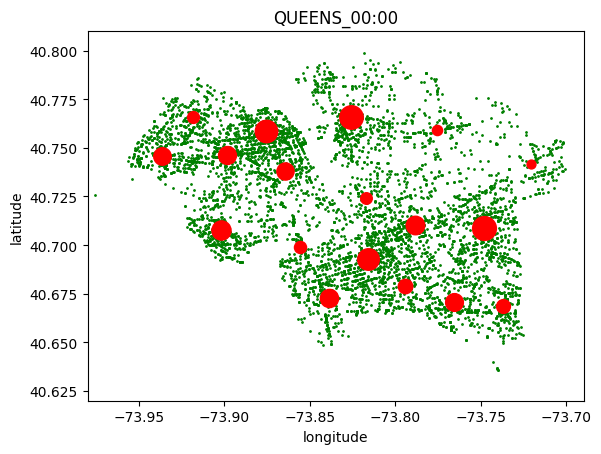

In [7]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_00:00")

In [8]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.67073202916666, -73.76578642109375, 384],
 [40.74617121670951, -73.89829644370178, 387],
 [40.766048263905326, -73.82579703234715, 507],
 [40.586949675, -73.83058880875002, 80],
 [40.74153324166667, -73.72068749322915, 192],
 [40.699273621072805, -73.85583513793104, 261],
 [40.67306319365481, -73.83858338781725, 393],
 [40.70892898817829, -73.74824518895349, 514],
 [40.759239849082576, -73.7756881440367, 220],
 [40.71023295275, -73.78824999575001, 400],
 [40.70785993671498, -73.90175494009662, 414],
 [40.73834043888889, -73.86436229100528, 371],
 [40.765648299609374, -73.91834790898437, 256],
 [40.74592808310992, -73.93662468900803, 378],
 [40.6688008173913, -73.73699823946488, 299],
 [40.6789880767516, -73.79453345796179, 313],
 [40.692615746120694, -73.81581814094825, 465],
 [40.75843521621621, -73.87552765010398, 485],
 [40.59934859770992, -73.76519601603057, 131],
 [40.72424140441766, -73.81722982329316, 250]]

### 01:00

In [9]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='01:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+------------------+-------+--------+--------------------+
| latitude|         longitude|borough|    time|            features|
+---------+------------------+-------+--------+--------------------+
| 40.78322|         -73.84586| QUEENS|01:00:00|[40.78322,-73.84586]|
| 40.76151|         -73.88361| QUEENS|01:00:00|[40.76151,-73.88361]|
|40.748985|         -73.89162| QUEENS|01:00:00|[40.748985,-73.89...|
| 40.78935|        -73.842804| QUEENS|01:00:00|[40.78935,-73.842...|
| 40.74456|         -73.93076| QUEENS|01:00:00|[40.74456,-73.93076]|
|40.693295|         -73.80802| QUEENS|01:00:00|[40.693295,-73.80...|
|40.746353|         -73.91617| QUEENS|01:00:00|[40.746353,-73.91...|
| 40.70835|         -73.81325| QUEENS|01:00:00|[40.70835,-73.81325]|
| 40.71307|         -73.75362| QUEENS|01:00:00|[40.71307,-73.75362]|
|40.711777|         -73.85928| QUEENS|01:00:00|[40.711777,-73.85...|
| 40.75945|         -73.87269| QUEENS|01:00:00|[40.75945,-73.87269]|
|40.757442|         -73.86747| QUE

In [10]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+------------------+-------+--------+--------------------+----------+
| latitude|         longitude|borough|    time|            features|prediction|
+---------+------------------+-------+--------+--------------------+----------+
| 40.78322|         -73.84586| QUEENS|01:00:00|[40.78322,-73.84586]|         3|
| 40.76151|         -73.88361| QUEENS|01:00:00|[40.76151,-73.88361]|        17|
|40.748985|         -73.89162| QUEENS|01:00:00|[40.748985,-73.89...|        17|
| 40.78935|        -73.842804| QUEENS|01:00:00|[40.78935,-73.842...|         3|
| 40.74456|         -73.93076| QUEENS|01:00:00|[40.74456,-73.93076]|         4|
|40.693295|         -73.80802| QUEENS|01:00:00|[40.693295,-73.80...|        15|
|40.746353|         -73.91617| QUEENS|01:00:00|[40.746353,-73.91...|         4|
| 40.70835|         -73.81325| QUEENS|01:00:00|[40.70835,-73.81325]|         6|
| 40.71307|         -73.75362| QUEENS|01:00:00|[40.71307,-73.75362]|        12|
|40.711777|         -73.85928| QUEENS|01

Text(0.5, 1.0, 'QUEENS_01:00')

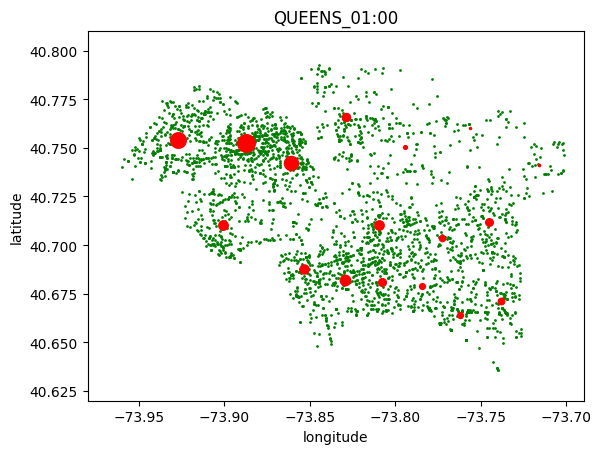

In [11]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_01:00")

In [12]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.68202845196507, -73.8296160231441, 224],
 [40.71036071990291, -73.90067427718445, 205],
 [40.671377063571434, -73.73818849928571, 140],
 [40.76591512057142, -73.8289464497143, 175],
 [40.7537987407738, -73.92736975684524, 336],
 [40.60033874468085, -73.76013355319148, 47],
 [40.710540018811884, -73.80980267376238, 203],
 [40.6789168952, -73.78425054320002, 125],
 [40.57688772727273, -73.8510950909091, 11],
 [40.741166959999994, -73.71574996400001, 50],
 [40.74217453800001, -73.86124598666667, 304],
 [40.663880637007864, -73.76193433700786, 127],
 [40.711828282926824, -73.74519483170731, 164],
 [40.687936820398015, -73.85354715273633, 198],
 [40.750375085365846, -73.79457925609756, 82],
 [40.68099211666667, -73.80810720432098, 167],
 [40.76021842444445, -73.75640612222223, 45],
 [40.752500144531254, -73.88745992265623, 380],
 [40.703850599999996, -73.77284789007633, 134],
 [40.59418361071428, -73.80660044642858, 28]]

### 02:00

In [13]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='02:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
|40.653023| -73.73895| QUEENS|02:00:00|[40.653023,-73.73...|
| 40.66901| -73.80265| QUEENS|02:00:00|[40.66901,-73.80265]|
|40.683323| -73.80648| QUEENS|02:00:00|[40.683323,-73.80...|
| 40.66563| -73.73921| QUEENS|02:00:00|[40.66563,-73.73921]|
|40.749744|-73.884315| QUEENS|02:00:00|[40.749744,-73.88...|
|40.756557| -73.87594| QUEENS|02:00:00|[40.756557,-73.87...|
| 40.72696|-73.846535| QUEENS|02:00:00|[40.72696,-73.846...|
|40.734272|  -73.8626| QUEENS|02:00:00|[40.734272,-73.8626]|
| 40.71474| -73.88698| QUEENS|02:00:00|[40.71474,-73.88698]|
| 40.67306| -73.82593| QUEENS|02:00:00|[40.67306,-73.82593]|
| 40.67546| -73.73385| QUEENS|02:00:00|[40.67546,-73.73385]|
|40.710777| -73.86502| QUEENS|02:00:00|[40.710777,-73.86...|
|40.711735| -73.73662| QUEENS|02:00:00|[40.711735,-73.73...|
| 40.72772| -73.84914| Q

In [14]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
|40.653023| -73.73895| QUEENS|02:00:00|[40.653023,-73.73...|        17|
| 40.66901| -73.80265| QUEENS|02:00:00|[40.66901,-73.80265]|        12|
|40.683323| -73.80648| QUEENS|02:00:00|[40.683323,-73.80...|        12|
| 40.66563| -73.73921| QUEENS|02:00:00|[40.66563,-73.73921]|        17|
|40.749744|-73.884315| QUEENS|02:00:00|[40.749744,-73.88...|         1|
|40.756557| -73.87594| QUEENS|02:00:00|[40.756557,-73.87...|        14|
| 40.72696|-73.846535| QUEENS|02:00:00|[40.72696,-73.846...|        14|
|40.734272|  -73.8626| QUEENS|02:00:00|[40.734272,-73.8626]|        14|
| 40.71474| -73.88698| QUEENS|02:00:00|[40.71474,-73.88698]|         6|
| 40.67306| -73.82593| QUEENS|02:00:00|[40.67306,-73.82593]|        15|
| 40.67546| -73.73385| QUEENS|02:00:00|[40.67546,-73.73385]|    

Text(0.5, 1.0, 'QUEENS_02:00')

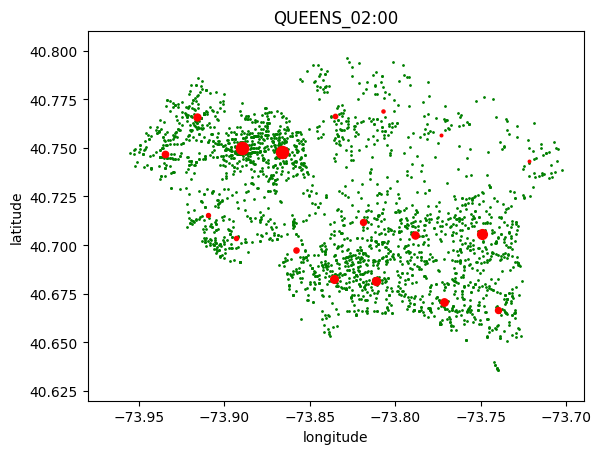

In [15]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_02:00")

In [16]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.74324975185185, -73.72175162777778, 54],
 [40.74994002537878, -73.88946935871213, 264],
 [40.71197625348837, -73.8191077387597, 129],
 [40.76899366323529, -73.80752010441176, 68],
 [40.670746978124996, -73.77181384999999, 160],
 [40.74707251824817, -73.93469406934307, 137],
 [40.70368101348315, -73.89322045280896, 89],
 [40.705238078571426, -73.7883723396104, 154],
 [40.6005321387755, -73.76541360408162, 49],
 [40.76653867789474, -73.83513132, 95],
 [40.715321910465114, -73.90932418372094, 86],
 [40.69762876785714, -73.85835644642857, 112],
 [40.68135027456648, -73.81144037919074, 173],
 [40.705927725592424, -73.74957327772512, 211],
 [40.74810766360152, -73.86620469080461, 261],
 [40.6825048879518, -73.83605445060239, 166],
 [40.765791306622525, -73.91604817682119, 151],
 [40.666666783076934, -73.74024884846153, 130],
 [40.756624976785716, -73.773310525, 56],
 [40.58383772727273, -73.83119590909088, 22]]

### 03:00

In [17]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='03:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
|40.748318| -73.87742| QUEENS|03:00:00|[40.748318,-73.87...|
| 40.67897| -73.75985| QUEENS|03:00:00|[40.67897,-73.75985]|
|40.685585| -73.78584| QUEENS|03:00:00|[40.685585,-73.78...|
|40.743614|-73.875275| QUEENS|03:00:00|[40.743614,-73.87...|
|40.739094| -73.91762| QUEENS|03:00:00|[40.739094,-73.91...|
|40.752068|-73.862854| QUEENS|03:00:00|[40.752068,-73.86...|
|40.749176|  -73.8897| QUEENS|03:00:00|[40.749176,-73.8897]|
| 40.77386| -73.90749| QUEENS|03:00:00|[40.77386,-73.90749]|
|40.728146|  -73.9003| QUEENS|03:00:00|[40.728146,-73.9003]|
| 40.72312| -73.90607| QUEENS|03:00:00|[40.72312,-73.90607]|
|40.688244| -73.82399| QUEENS|03:00:00|[40.688244,-73.82...|
|40.762657| -73.87326| QUEENS|03:00:00|[40.762657,-73.87...|
|40.743793| -73.88472| QUEENS|03:00:00|[40.743793,-73.88...|
|40.705715| -73.91259| Q

In [18]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
|40.748318| -73.87742| QUEENS|03:00:00|[40.748318,-73.87...|        16|
| 40.67897| -73.75985| QUEENS|03:00:00|[40.67897,-73.75985]|         5|
|40.685585| -73.78584| QUEENS|03:00:00|[40.685585,-73.78...|         1|
|40.743614|-73.875275| QUEENS|03:00:00|[40.743614,-73.87...|        16|
|40.739094| -73.91762| QUEENS|03:00:00|[40.739094,-73.91...|        19|
|40.752068|-73.862854| QUEENS|03:00:00|[40.752068,-73.86...|        16|
|40.749176|  -73.8897| QUEENS|03:00:00|[40.749176,-73.8897]|         7|
| 40.77386| -73.90749| QUEENS|03:00:00|[40.77386,-73.90749]|         0|
|40.728146|  -73.9003| QUEENS|03:00:00|[40.728146,-73.9003]|         8|
| 40.72312| -73.90607| QUEENS|03:00:00|[40.72312,-73.90607]|         8|
|40.688244| -73.82399| QUEENS|03:00:00|[40.688244,-73.82...|    

Text(0.5, 1.0, 'QUEENS_03:00')

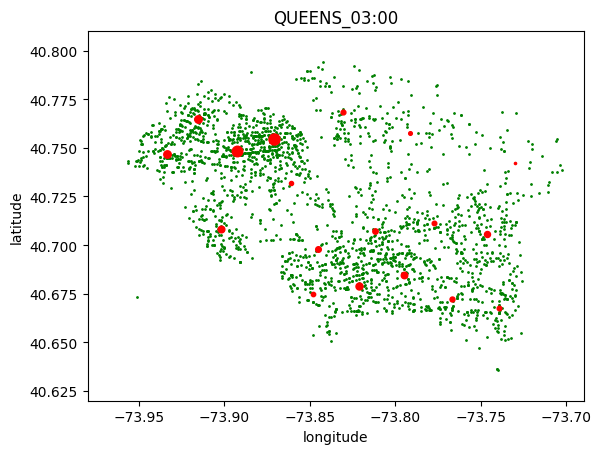

In [19]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_03:00")

In [20]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.76470706296296, -73.91564672407407, 162],
 [40.68482219214285, -73.79477226285712, 140],
 [40.768561174038474, -73.8306430375, 104],
 [40.592260677272726, -73.82705437727273, 22],
 [40.757386358750004, -73.79155519125, 80],
 [40.67244241944444, -73.7667943537037, 108],
 [40.74225131458334, -73.73026233124999, 48],
 [40.74815858991228, -73.89260519692984, 228],
 [40.70837972896552, -73.90184814689654, 145],
 [40.697849406557374, -73.84548316147541, 122],
 [40.70587866153847, -73.74652723923077, 130],
 [40.679064523684204, -73.8213539355263, 152],
 [40.711210623999996, -73.77757590699999, 100],
 [40.731707030337084, -73.86120305393258, 89],
 [40.70732657264958, -73.81205474957265, 117],
 [40.59865962195122, -73.76414434390244, 41],
 [40.754541748535544, -73.87092087824267, 239],
 [40.667862671, -73.739179217, 100],
 [40.674876145744676, -73.84835307765958, 94],
 [40.74687517142856, -73.93347445093166, 161]]

### 04:00

In [21]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='04:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
|40.702972|-73.888054| QUEENS|04:00:00|[40.702972,-73.88...|
| 40.76104| -73.88162| QUEENS|04:00:00|[40.76104,-73.88162]|
|40.763496| -73.87814| QUEENS|04:00:00|[40.763496,-73.87...|
|40.693882| -73.72966| QUEENS|04:00:00|[40.693882,-73.72...|
|40.688755| -73.86094| QUEENS|04:00:00|[40.688755,-73.86...|
|40.666397|-73.755516| QUEENS|04:00:00|[40.666397,-73.75...|
| 40.59957| -73.76422| QUEENS|04:00:00|[40.59957,-73.76422]|
|40.747135| -73.85978| QUEENS|04:00:00|[40.747135,-73.85...|
|  40.6928|-73.895065| QUEENS|04:00:00|[40.6928,-73.895065]|
| 40.75585| -73.88259| QUEENS|04:00:00|[40.75585,-73.88259]|
|40.689735| -73.74729| QUEENS|04:00:00|[40.689735,-73.74...|
| 40.73007| -73.80718| QUEENS|04:00:00|[40.73007,-73.80718]|
| 40.69405| -73.82802| QUEENS|04:00:00|[40.69405,-73.82802]|
| 40.74344| -73.87675| Q

In [22]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
|40.702972|-73.888054| QUEENS|04:00:00|[40.702972,-73.88...|        18|
| 40.76104| -73.88162| QUEENS|04:00:00|[40.76104,-73.88162]|        16|
|40.763496| -73.87814| QUEENS|04:00:00|[40.763496,-73.87...|        16|
|40.693882| -73.72966| QUEENS|04:00:00|[40.693882,-73.72...|        12|
|40.688755| -73.86094| QUEENS|04:00:00|[40.688755,-73.86...|        14|
|40.666397|-73.755516| QUEENS|04:00:00|[40.666397,-73.75...|         5|
| 40.59957| -73.76422| QUEENS|04:00:00|[40.59957,-73.76422]|         1|
|40.747135| -73.85978| QUEENS|04:00:00|[40.747135,-73.85...|         9|
|  40.6928|-73.895065| QUEENS|04:00:00|[40.6928,-73.895065]|        18|
| 40.75585| -73.88259| QUEENS|04:00:00|[40.75585,-73.88259]|        16|
|40.689735| -73.74729| QUEENS|04:00:00|[40.689735,-73.74...|    

Text(0.5, 1.0, 'QUEENS_04:00')

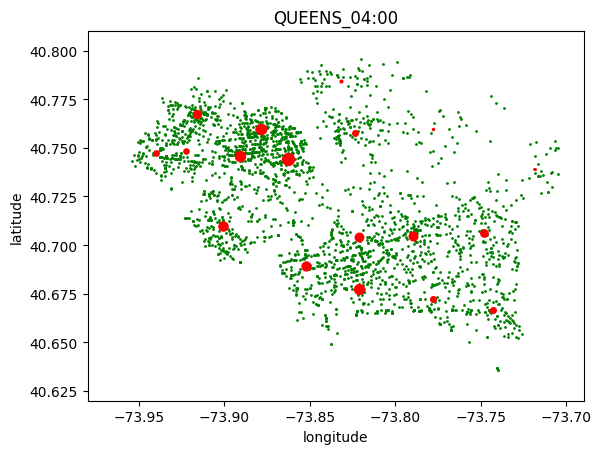

In [23]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_04:00")

In [24]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.70433613825137, -73.82103237213114, 183],
 [40.59648060625, -73.7798636171875, 64],
 [40.74574516221197, -73.89111679447004, 217],
 [40.73906108571429, -73.71810300285713, 35],
 [40.759656402173924, -73.77802447608697, 46],
 [40.66677757355372, -73.74303379999999, 121],
 [40.67742990981308, -73.82127160140186, 214],
 [40.586530999999994, -73.96132, 2],
 [40.767420330994156, -73.9161974877193, 171],
 [40.74418772490272, -73.86285234007782, 257],
 [40.7472173862069, -73.94020896206895, 116],
 [40.748215506194704, -73.92245107699115, 113],
 [40.706227625625, -73.74791560625, 160],
 [40.757375155371896, -73.82366887272728, 121],
 [40.6893829390625, -73.85249412916667, 192],
 [40.67237274796748, -73.77784838373985, 123],
 [40.75965208669725, -73.87864940825689, 218],
 [40.704717697311835, -73.78967136612904, 186],
 [40.70964737309644, -73.90073260456852, 197],
 [40.784614342372876, -73.83168350000001, 59]]

### 05:00

In [25]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='05:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
| 40.69614| -73.81789| QUEENS|05:00:00|[40.69614,-73.81789]|
|40.753994| -73.94244| QUEENS|05:00:00|[40.753994,-73.94...|
|40.666454| -73.78413| QUEENS|05:00:00|[40.666454,-73.78...|
|40.597824|-73.782524| QUEENS|05:00:00|[40.597824,-73.78...|
|40.766743| -73.92597| QUEENS|05:00:00|[40.766743,-73.92...|
|40.686234| -73.82418| QUEENS|05:00:00|[40.686234,-73.82...|
|40.790718| -73.84991| QUEENS|05:00:00|[40.790718,-73.84...|
| 40.69405| -73.82802| QUEENS|05:00:00|[40.69405,-73.82802]|
|40.682514| -73.75665| QUEENS|05:00:00|[40.682514,-73.75...|
|40.749744|-73.884315| QUEENS|05:00:00|[40.749744,-73.88...|
|40.745773|-73.890274| QUEENS|05:00:00|[40.745773,-73.89...|
|40.766434| -73.83767| QUEENS|05:00:00|[40.766434,-73.83...|
|40.665257|-73.739555| QUEENS|05:00:00|[40.665257,-73.73...|
| 40.65616| -73.76736| Q

In [26]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
| 40.69614| -73.81789| QUEENS|05:00:00|[40.69614,-73.81789]|        15|
|40.753994| -73.94244| QUEENS|05:00:00|[40.753994,-73.94...|        14|
|40.666454| -73.78413| QUEENS|05:00:00|[40.666454,-73.78...|         7|
|40.597824|-73.782524| QUEENS|05:00:00|[40.597824,-73.78...|         4|
|40.766743| -73.92597| QUEENS|05:00:00|[40.766743,-73.92...|         1|
|40.686234| -73.82418| QUEENS|05:00:00|[40.686234,-73.82...|         3|
|40.790718| -73.84991| QUEENS|05:00:00|[40.790718,-73.84...|        13|
| 40.69405| -73.82802| QUEENS|05:00:00|[40.69405,-73.82802]|        15|
|40.682514| -73.75665| QUEENS|05:00:00|[40.682514,-73.75...|         7|
|40.749744|-73.884315| QUEENS|05:00:00|[40.749744,-73.88...|        18|
|40.745773|-73.890274| QUEENS|05:00:00|[40.745773,-73.89...|    

Text(0.5, 1.0, 'QUEENS_05:00')

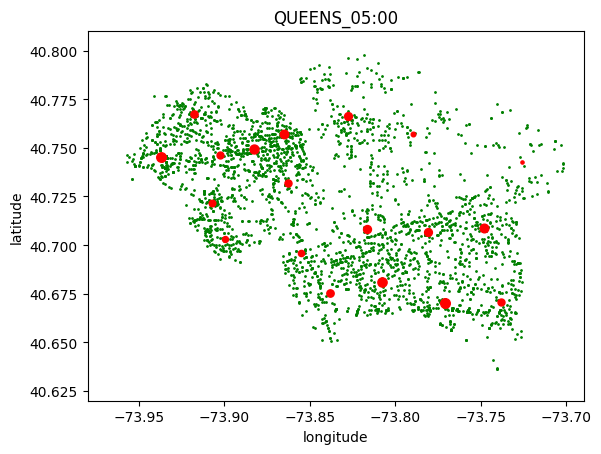

In [27]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_05:00")

In [28]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.75708634510869, -73.86503489565216, 184],
 [40.767296499367085, -73.9175297056962, 158],
 [40.70898501550802, -73.74821875133689, 187],
 [40.680890272, -73.80754803050002, 200],
 [40.59638200777778, -73.78461459333333, 90],
 [40.67091405960265, -73.738302105298, 151],
 [40.69604682014925, -73.85538563358207, 134],
 [40.67015167596154, -73.77090348942308, 208],
 [40.74648920132451, -73.90260109801324, 150],
 [40.703274082170545, -73.89942707441861, 129],
 [40.72145977272727, -73.90696857832168, 143],
 [40.675427467295606, -73.8379442245283, 159],
 [40.73208535761589, -73.86254940331128, 152],
 [40.766359189411766, -73.82766519941177, 170],
 [40.74529153592232, -73.93703715048542, 206],
 [40.70831475523255, -73.81636668546511, 172],
 [40.74286714782608, -73.7258400057971, 69],
 [40.70661898816569, -73.78114013786983, 169],
 [40.74964317010309, -73.88246550257732, 194],
 [40.756874507999996, -73.78994778799999, 100]]

### 06:00

In [29]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='06:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
| 40.75373| -73.88505| QUEENS|06:00:00|[40.75373,-73.88505]|
| 40.68651| -73.76815| QUEENS|06:00:00|[40.68651,-73.76815]|
| 40.73006|-73.710754| QUEENS|06:00:00|[40.73006,-73.710...|
| 40.68657|-73.776146| QUEENS|06:00:00|[40.68657,-73.776...|
| 40.74734| -73.88673| QUEENS|06:00:00|[40.74734,-73.88673]|
|40.670017|-73.746185| QUEENS|06:00:00|[40.670017,-73.74...|
| 40.74832| -73.87729| QUEENS|06:00:00|[40.74832,-73.87729]|
|40.766827|-73.909294| QUEENS|06:00:00|[40.766827,-73.90...|
| 40.72711| -73.80509| QUEENS|06:00:00|[40.72711,-73.80509]|
|40.726135| -73.82638| QUEENS|06:00:00|[40.726135,-73.82...|
|40.754612| -73.87667| QUEENS|06:00:00|[40.754612,-73.87...|
| 40.74656| -73.89413| QUEENS|06:00:00|[40.74656,-73.89413]|
|40.745792|-73.876564| QUEENS|06:00:00|[40.745792,-73.87...|
| 40.71911| -73.76679| Q

In [30]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
| 40.75373| -73.88505| QUEENS|06:00:00|[40.75373,-73.88505]|        10|
| 40.68651| -73.76815| QUEENS|06:00:00|[40.68651,-73.76815]|        15|
| 40.73006|-73.710754| QUEENS|06:00:00|[40.73006,-73.710...|         5|
| 40.68657|-73.776146| QUEENS|06:00:00|[40.68657,-73.776...|        15|
| 40.74734| -73.88673| QUEENS|06:00:00|[40.74734,-73.88673]|        10|
|40.670017|-73.746185| QUEENS|06:00:00|[40.670017,-73.74...|         7|
| 40.74832| -73.87729| QUEENS|06:00:00|[40.74832,-73.87729]|        10|
|40.766827|-73.909294| QUEENS|06:00:00|[40.766827,-73.90...|        11|
| 40.72711| -73.80509| QUEENS|06:00:00|[40.72711,-73.80509]|        13|
|40.726135| -73.82638| QUEENS|06:00:00|[40.726135,-73.82...|        13|
|40.754612| -73.87667| QUEENS|06:00:00|[40.754612,-73.87...|    

Text(0.5, 1.0, 'QUEENS_06:00')

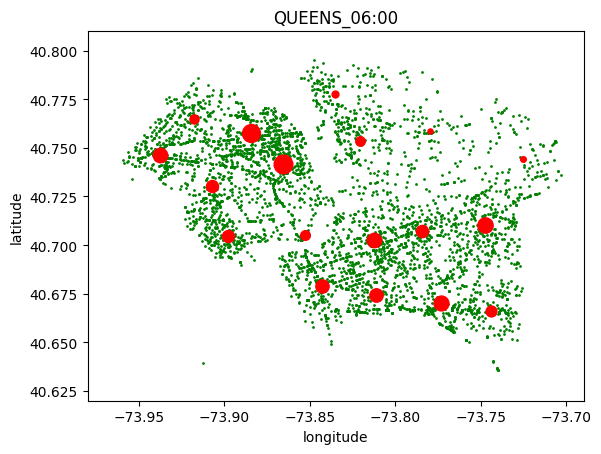

In [31]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_06:00")

In [32]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.67418214930555, -73.8115842309028, 289],
 [40.746567318210865, -73.93777912971245, 313],
 [40.60025555568181, -73.75889517954545, 88],
 [40.705157706603785, -73.85256021509434, 209],
 [40.710505950303016, -73.74757852636364, 331],
 [40.74451041639345, -73.72534506147544, 122],
 [40.75344095485436, -73.82050989563109, 206],
 [40.66618788893616, -73.74420570851065, 235],
 [40.704878884046686, -73.89787939260701, 260],
 [40.777907655704695, -73.83510669127519, 149],
 [40.75774547197943, -73.88448885398456, 388],
 [40.764902688442206, -73.91762442864322, 197],
 [40.67886782175439, -73.84281150105264, 287],
 [40.7028694224359, -73.8123500150641, 312],
 [40.707175978358215, -73.78462973171641, 264],
 [40.670421902173906, -73.77327534906833, 322],
 [40.74147325185186, -73.86571110098765, 404],
 [40.58811168888888, -73.8171955095238, 63],
 [40.730630868076936, -73.90729945076923, 260],
 [40.75860539532709, -73.77968812429906, 111]]

### 07:00

In [33]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='07:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
|40.674263| -73.80453| QUEENS|07:00:00|[40.674263,-73.80...|
| 40.72609|-73.830154| QUEENS|07:00:00|[40.72609,-73.830...|
|40.733597| -73.91062| QUEENS|07:00:00|[40.733597,-73.91...|
| 40.60871| -73.74768| QUEENS|07:00:00|[40.60871,-73.74768]|
|  40.7075|-73.800674| QUEENS|07:00:00|[40.7075,-73.800674]|
|40.709152| -73.87173| QUEENS|07:00:00|[40.709152,-73.87...|
|40.742123| -73.92745| QUEENS|07:00:00|[40.742123,-73.92...|
|40.772495|  -73.8303| QUEENS|07:00:00|[40.772495,-73.8303]|
|40.669876| -73.84741| QUEENS|07:00:00|[40.669876,-73.84...|
|40.778603|-73.846115| QUEENS|07:00:00|[40.778603,-73.84...|
|40.702793| -73.83214| QUEENS|07:00:00|[40.702793,-73.83...|
|40.702084| -73.88966| QUEENS|07:00:00|[40.702084,-73.88...|
|40.606018| -73.75124| QUEENS|07:00:00|[40.606018,-73.75...|
|40.595444|-73.779045| Q

In [34]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
|40.674263| -73.80453| QUEENS|07:00:00|[40.674263,-73.80...|        14|
| 40.72609|-73.830154| QUEENS|07:00:00|[40.72609,-73.830...|         0|
|40.733597| -73.91062| QUEENS|07:00:00|[40.733597,-73.91...|         1|
| 40.60871| -73.74768| QUEENS|07:00:00|[40.60871,-73.74768]|         2|
|  40.7075|-73.800674| QUEENS|07:00:00|[40.7075,-73.800674]|         5|
|40.709152| -73.87173| QUEENS|07:00:00|[40.709152,-73.87...|        13|
|40.742123| -73.92745| QUEENS|07:00:00|[40.742123,-73.92...|         9|
|40.772495|  -73.8303| QUEENS|07:00:00|[40.772495,-73.8303]|         7|
|40.669876| -73.84741| QUEENS|07:00:00|[40.669876,-73.84...|         6|
|40.778603|-73.846115| QUEENS|07:00:00|[40.778603,-73.84...|         7|
|40.702793| -73.83214| QUEENS|07:00:00|[40.702793,-73.83...|    

Text(0.5, 1.0, 'QUEENS_07:00')

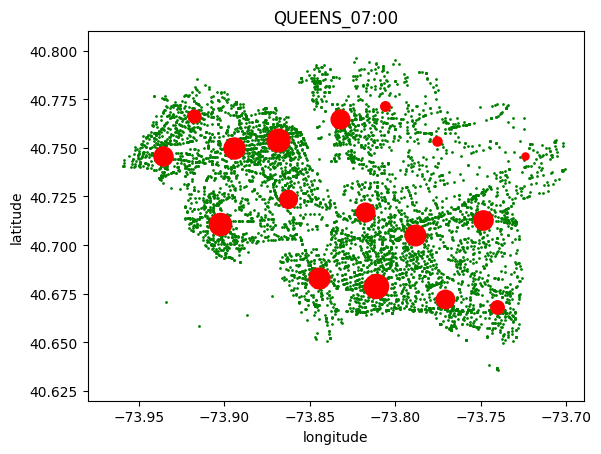

In [35]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_07:00")

In [36]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.71726294925743, -73.81749405816832, 404],
 [40.74966289327355, -73.89411231860987, 455],
 [40.599720656565665, -73.76168378636365, 198],
 [40.58890792295082, -73.81971764836065, 122],
 [40.668006580412374, -73.74041628556702, 291],
 [40.7050727054054, -73.7883281168919, 444],
 [40.683340960133634, -73.84482756971047, 449],
 [40.76494195456791, -73.83255537876545, 405],
 [40.75343859696971, -73.77550114343435, 198],
 [40.74567021094891, -73.9359895540146, 411],
 [40.71308301942447, -73.74897178225419, 417],
 [40.71071024088051, -73.90275963291406, 477],
 [40.67207618746867, -73.77085412481202, 399],
 [40.72393913707572, -73.86289148067887, 384],
 [40.67916617466411, -73.81139660287909, 521],
 [40.74580894183006, -73.72420350457517, 153],
 [40.76636956498195, -73.91795030866427, 278],
 [40.75409131633466, -73.8685048434263, 491],
 [40.771486933816426, -73.80589452125602, 207],
 [40.5606365, -73.91304275, 4]]

### 08:00

In [37]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='08:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+------------------+-------+--------+--------------------+
| latitude|         longitude|borough|    time|            features|
+---------+------------------+-------+--------+--------------------+
| 40.60675|        -73.756645| QUEENS|08:00:00|[40.60675,-73.756...|
|40.775414|         -73.91984| QUEENS|08:00:00|[40.775414,-73.91...|
|40.727913|        -73.873245| QUEENS|08:00:00|[40.727913,-73.87...|
| 40.73973|         -73.70625| QUEENS|08:00:00|[40.73973,-73.70625]|
| 40.72119|        -73.761185| QUEENS|08:00:00|[40.72119,-73.761...|
|40.704563|-73.91066000000001| QUEENS|08:00:00|[40.704563,-73.91...|
| 40.67875|           -73.794| QUEENS|08:00:00|  [40.67875,-73.794]|
|40.658947|         -73.73472| QUEENS|08:00:00|[40.658947,-73.73...|
|40.687843|         -73.82005| QUEENS|08:00:00|[40.687843,-73.82...|
| 40.73444|         -73.72179| QUEENS|08:00:00|[40.73444,-73.72179]|
|40.752045|        -73.879036| QUEENS|08:00:00|[40.752045,-73.87...|
| 40.73994|        -73.850266| QUE

In [38]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+------------------+-------+--------+--------------------+----------+
| latitude|         longitude|borough|    time|            features|prediction|
+---------+------------------+-------+--------+--------------------+----------+
| 40.60675|        -73.756645| QUEENS|08:00:00|[40.60675,-73.756...|         5|
|40.775414|         -73.91984| QUEENS|08:00:00|[40.775414,-73.91...|         6|
|40.727913|        -73.873245| QUEENS|08:00:00|[40.727913,-73.87...|        12|
| 40.73973|         -73.70625| QUEENS|08:00:00|[40.73973,-73.70625]|        18|
| 40.72119|        -73.761185| QUEENS|08:00:00|[40.72119,-73.761...|         9|
|40.704563|-73.91066000000001| QUEENS|08:00:00|[40.704563,-73.91...|         2|
| 40.67875|           -73.794| QUEENS|08:00:00|  [40.67875,-73.794]|        14|
|40.658947|         -73.73472| QUEENS|08:00:00|[40.658947,-73.73...|         7|
|40.687843|         -73.82005| QUEENS|08:00:00|[40.687843,-73.82...|        15|
| 40.73444|         -73.72179| QUEENS|08

Text(0.5, 1.0, 'QUEENS_08:00')

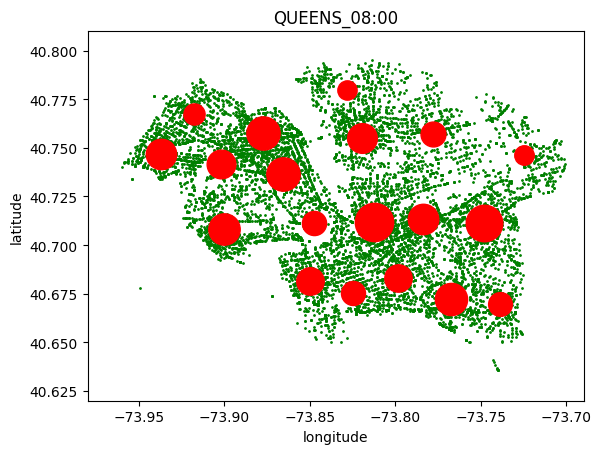

In [39]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_08:00")

In [40]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.67209338782235, -73.76760827636103, 696],
 [40.74687875145482, -73.93721983506892, 657],
 [40.70803308839286, -73.90012904241073, 678],
 [40.77996938477752, -73.82809644145199, 417],
 [40.757140050371746, -73.77800168866169, 538],
 [40.596395473333324, -73.77769466074074, 540],
 [40.767600769631244, -73.91761327266812, 458],
 [40.66989746418786, -73.73908114911939, 513],
 [40.71169481765417, -73.81235167738815, 829],
 [40.71153131024021, -73.74813498786347, 790],
 [40.68145349966272, -73.85005666222597, 594],
 [40.71358364326778, -73.78381451361574, 658],
 [40.73663144309392, -73.86552272417126, 721],
 [40.74169905089431, -73.90219113967481, 620],
 [40.68286811167513, -73.79827365414552, 592],
 [40.67517355155038, -73.82477356240311, 519],
 [40.75750610767124, -73.87749546726029, 719],
 [40.71144518829175, -73.8475034731286, 522],
 [40.74652578171021, -73.72458440403801, 421],
 [40.754853497318614, -73.81933672823344, 642]]

### 09:00

In [41]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='09:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
| 40.70447| -73.90148| QUEENS|09:00:00|[40.70447,-73.90148]|
|40.743534| -73.93951| QUEENS|09:00:00|[40.743534,-73.93...|
| 40.69558|-73.788704| QUEENS|09:00:00|[40.69558,-73.788...|
|40.694748| -73.73427| QUEENS|09:00:00|[40.694748,-73.73...|
|  40.7406| -73.81025| QUEENS|09:00:00| [40.7406,-73.81025]|
|40.677876| -73.85064| QUEENS|09:00:00|[40.677876,-73.85...|
|40.667114|-73.834656| QUEENS|09:00:00|[40.667114,-73.83...|
|40.757847| -73.89922| QUEENS|09:00:00|[40.757847,-73.89...|
| 40.60531|-73.759056| QUEENS|09:00:00|[40.60531,-73.759...|
|40.597435| -73.74713| QUEENS|09:00:00|[40.597435,-73.74...|
|40.757084| -73.91614| QUEENS|09:00:00|[40.757084,-73.91...|
| 40.74624| -73.89723| QUEENS|09:00:00|[40.74624,-73.89723]|
|40.750626| -73.87595| QUEENS|09:00:00|[40.750626,-73.87...|
|40.720154| -73.87531| Q

In [42]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
| 40.70447| -73.90148| QUEENS|09:00:00|[40.70447,-73.90148]|         9|
|40.743534| -73.93951| QUEENS|09:00:00|[40.743534,-73.93...|         1|
| 40.69558|-73.788704| QUEENS|09:00:00|[40.69558,-73.788...|        15|
|40.694748| -73.73427| QUEENS|09:00:00|[40.694748,-73.73...|         5|
|  40.7406| -73.81025| QUEENS|09:00:00| [40.7406,-73.81025]|        18|
|40.677876| -73.85064| QUEENS|09:00:00|[40.677876,-73.85...|         3|
|40.667114|-73.834656| QUEENS|09:00:00|[40.667114,-73.83...|         8|
|40.757847| -73.89922| QUEENS|09:00:00|[40.757847,-73.89...|        10|
| 40.60531|-73.759056| QUEENS|09:00:00|[40.60531,-73.759...|        11|
|40.597435| -73.74713| QUEENS|09:00:00|[40.597435,-73.74...|        11|
|40.757084| -73.91614| QUEENS|09:00:00|[40.757084,-73.91...|    

Text(0.5, 1.0, 'QUEENS_09:00')

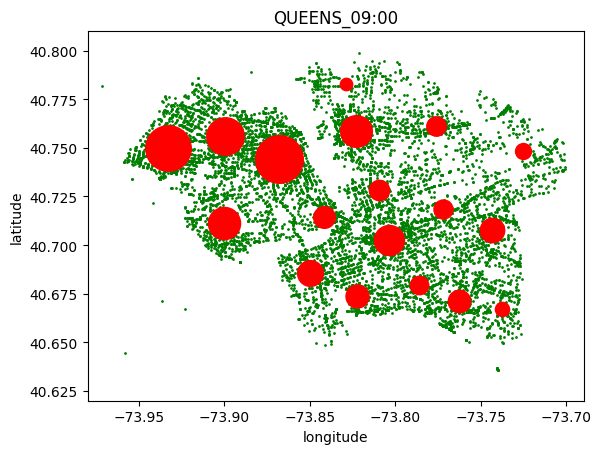

In [43]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_09:00")

In [44]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.7585412919708, -73.8230712947445, 685],
 [40.74982643279352, -73.93315360080973, 983],
 [40.666929786644964, -73.7377119889251, 307],
 [40.68582577661871, -73.84968999154677, 556],
 [40.70247381848484, -73.80386509424243, 649],
 [40.70756355229885, -73.74342014827585, 527],
 [40.74816995510204, -73.72521306501459, 344],
 [40.586246630534355, -73.82549673587788, 131],
 [40.673710324698796, -73.82266592710842, 497],
 [40.711163910230546, -73.90014989481267, 694],
 [40.756156537407406, -73.899728174321, 809],
 [40.600853546103906, -73.75899584253249, 308],
 [40.74432085111977, -73.86797118977606, 1029],
 [40.71426169764454, -73.84198711327626, 468],
 [40.761297026904764, -73.77597712095239, 420],
 [40.6792671279597, -73.78642426397984, 399],
 [40.67125711484535, -73.76296836721649, 485],
 [40.71870939432099, -73.77241808, 412],
 [40.72845931025057, -73.8096033353075, 439],
 [40.782629391417906, -73.82897300708954, 268]]

### 10:00

In [45]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='10:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
|40.692596| -73.79078| QUEENS|10:00:00|[40.692596,-73.79...|
|40.692127| -73.83484| QUEENS|10:00:00|[40.692127,-73.83...|
|40.600792| -73.76711| QUEENS|10:00:00|[40.600792,-73.76...|
| 40.59723| -73.76237| QUEENS|10:00:00|[40.59723,-73.76237]|
|40.680496|-73.821365| QUEENS|10:00:00|[40.680496,-73.82...|
|40.745766| -73.86421| QUEENS|10:00:00|[40.745766,-73.86...|
|40.687046|-73.792114| QUEENS|10:00:00|[40.687046,-73.79...|
|40.713173| -73.90076| QUEENS|10:00:00|[40.713173,-73.90...|
| 40.69802|  -73.7623| QUEENS|10:00:00| [40.69802,-73.7623]|
| 40.74217|-73.804436| QUEENS|10:00:00|[40.74217,-73.804...|
|40.769794| -73.90045| QUEENS|10:00:00|[40.769794,-73.90...|
|40.697556| -73.80498| QUEENS|10:00:00|[40.697556,-73.80...|
|40.698055|  -73.7877| QUEENS|10:00:00|[40.698055,-73.7877]|
|40.595158|  -73.7543| Q

In [46]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
|40.692596| -73.79078| QUEENS|10:00:00|[40.692596,-73.79...|         9|
|40.692127| -73.83484| QUEENS|10:00:00|[40.692127,-73.83...|         3|
|40.600792| -73.76711| QUEENS|10:00:00|[40.600792,-73.76...|         6|
| 40.59723| -73.76237| QUEENS|10:00:00|[40.59723,-73.76237]|         6|
|40.680496|-73.821365| QUEENS|10:00:00|[40.680496,-73.82...|         3|
|40.745766| -73.86421| QUEENS|10:00:00|[40.745766,-73.86...|         8|
|40.687046|-73.792114| QUEENS|10:00:00|[40.687046,-73.79...|         9|
|40.713173| -73.90076| QUEENS|10:00:00|[40.713173,-73.90...|        10|
| 40.69802|  -73.7623| QUEENS|10:00:00| [40.69802,-73.7623]|        13|
| 40.74217|-73.804436| QUEENS|10:00:00|[40.74217,-73.804...|         4|
|40.769794| -73.90045| QUEENS|10:00:00|[40.769794,-73.90...|    

Text(0.5, 1.0, 'QUEENS_10:00')

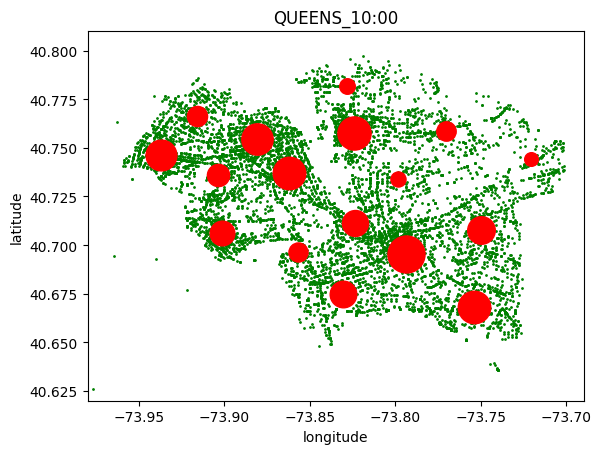

In [47]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_10:00")

In [48]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.66797880937501, -73.75402810411931, 702],
 [40.76617922591743, -73.91578177729359, 436],
 [40.57890772597403, -73.84698002857142, 77],
 [40.67496249114584, -73.83051083020833, 575],
 [40.73422214246988, -73.79869762198794, 326],
 [40.78155929228487, -73.82833834154302, 336],
 [40.60112792626728, -73.75624769400922, 217],
 [40.74417506040956, -73.72093495392492, 295],
 [40.736953979800845, -73.86243704267424, 703],
 [40.695625805597025, -73.79376927649254, 800],
 [40.70640307153558, -73.90117845599251, 534],
 [40.59279008625955, -73.8070011816794, 131],
 [40.69651899539952, -73.85699350750606, 413],
 [40.70788613557046, -73.75005146325502, 596],
 [40.75787366543386, -73.82423280398294, 717],
 [40.711589655866895, -73.82379006147109, 561],
 [40.74654125607196, -73.93710019790105, 665],
 [40.75872860338983, -73.77034522760292, 419],
 [40.75469389926362, -73.8811728298969, 678],
 [40.73581320505263, -73.90389900989473, 480]]

### 11:00

In [49]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='11:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
| 40.70546|  -73.7949| QUEENS|11:00:00| [40.70546,-73.7949]|
|40.737865|-73.876144| QUEENS|11:00:00|[40.737865,-73.87...|
|40.680077|-73.852684| QUEENS|11:00:00|[40.680077,-73.85...|
|40.694294| -73.74868| QUEENS|11:00:00|[40.694294,-73.74...|
| 40.74958| -73.86541| QUEENS|11:00:00|[40.74958,-73.86541]|
|40.681484| -73.85049| QUEENS|11:00:00|[40.681484,-73.85...|
| 40.69507| -73.80114| QUEENS|11:00:00|[40.69507,-73.80114]|
| 40.70326| -73.86474| QUEENS|11:00:00|[40.70326,-73.86474]|
|40.739525| -73.92512| QUEENS|11:00:00|[40.739525,-73.92...|
| 40.70675| -73.76271| QUEENS|11:00:00|[40.70675,-73.76271]|
|40.738354| -73.89591| QUEENS|11:00:00|[40.738354,-73.89...|
|40.709435| -73.73208| QUEENS|11:00:00|[40.709435,-73.73...|
|40.595203| -73.75603| QUEENS|11:00:00|[40.595203,-73.75...|
|40.771343|-73.905235| Q

In [50]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
| 40.70546|  -73.7949| QUEENS|11:00:00| [40.70546,-73.7949]|         4|
|40.737865|-73.876144| QUEENS|11:00:00|[40.737865,-73.87...|        10|
|40.680077|-73.852684| QUEENS|11:00:00|[40.680077,-73.85...|        16|
|40.694294| -73.74868| QUEENS|11:00:00|[40.694294,-73.74...|         5|
| 40.74958| -73.86541| QUEENS|11:00:00|[40.74958,-73.86541]|        10|
|40.681484| -73.85049| QUEENS|11:00:00|[40.681484,-73.85...|        16|
| 40.69507| -73.80114| QUEENS|11:00:00|[40.69507,-73.80114]|         4|
| 40.70326| -73.86474| QUEENS|11:00:00|[40.70326,-73.86474]|         6|
|40.739525| -73.92512| QUEENS|11:00:00|[40.739525,-73.92...|         1|
| 40.70675| -73.76271| QUEENS|11:00:00|[40.70675,-73.76271]|         5|
|40.738354| -73.89591| QUEENS|11:00:00|[40.738354,-73.89...|    

Text(0.5, 1.0, 'QUEENS_11:00')

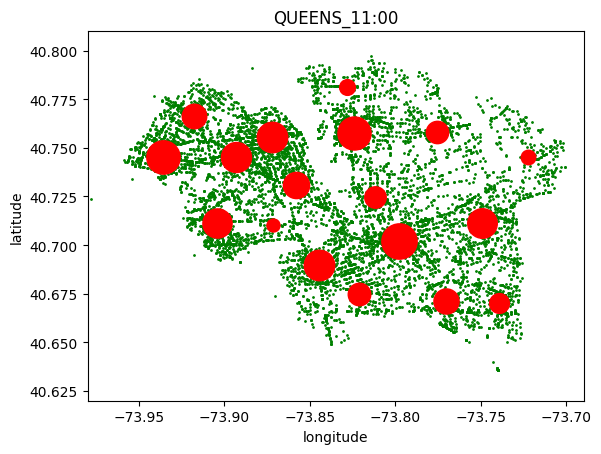

In [51]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_11:00")

In [52]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.72455242362031, -73.81192834834437, 464],
 [40.745123114979194, -73.93613981386962, 721],
 [40.781378324705884, -73.82828397558823, 340],
 [40.67019968621495, -73.73946311495327, 428],
 [40.70236231987012, -73.79769217155844, 763],
 [40.711234421996885, -73.74961412745711, 639],
 [40.710409751957286, -73.87174327935942, 281],
 [40.73108547961674, -73.85838235209062, 566],
 [40.586461984023664, -73.82956564556214, 169],
 [40.75785595802817, -73.8241457974648, 715],
 [40.75578358237082, -73.87243069148934, 658],
 [40.76620052415094, -73.91764907584906, 530],
 [40.59993140756303, -73.76080420462183, 238],
 [40.711128534706816, -73.90434850538827, 631],
 [40.74529135382165, -73.7224906990446, 314],
 [40.675112989896895, -73.82132852020618, 487],
 [40.689836773827544, -73.84469999288957, 659],
 [40.75813452645833, -73.77577131229168, 483],
 [40.67115596972477, -73.77041848146787, 543],
 [40.74534868520801, -73.89310115993838, 649]]

### 12:00

In [53]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='12:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
|40.747498| -73.91309| QUEENS|12:00:00|[40.747498,-73.91...|
| 40.75245| -73.94507| QUEENS|12:00:00|[40.75245,-73.94507]|
|40.721645|  -73.8026| QUEENS|12:00:00|[40.721645,-73.8026]|
| 40.72717| -73.78739| QUEENS|12:00:00|[40.72717,-73.78739]|
|  40.6974| -73.80952| QUEENS|12:00:00| [40.6974,-73.80952]|
|40.733017|  -73.8852| QUEENS|12:00:00|[40.733017,-73.8852]|
|40.708363| -73.87203| QUEENS|12:00:00|[40.708363,-73.87...|
|40.752556| -73.92972| QUEENS|12:00:00|[40.752556,-73.92...|
|40.724358|-73.742516| QUEENS|12:00:00|[40.724358,-73.74...|
|40.755337|-73.843254| QUEENS|12:00:00|[40.755337,-73.84...|
|40.697327| -73.82961| QUEENS|12:00:00|[40.697327,-73.82...|
|40.609913| -73.75364| QUEENS|12:00:00|[40.609913,-73.75...|
|40.676117| -73.74046| QUEENS|12:00:00|[40.676117,-73.74...|
|40.609592| -73.75854| Q

In [54]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
|40.747498| -73.91309| QUEENS|12:00:00|[40.747498,-73.91...|         8|
| 40.75245| -73.94507| QUEENS|12:00:00|[40.75245,-73.94507]|         4|
|40.721645|  -73.8026| QUEENS|12:00:00|[40.721645,-73.8026]|        18|
| 40.72717| -73.78739| QUEENS|12:00:00|[40.72717,-73.78739]|        18|
|  40.6974| -73.80952| QUEENS|12:00:00| [40.6974,-73.80952]|        12|
|40.733017|  -73.8852| QUEENS|12:00:00|[40.733017,-73.8852]|         8|
|40.708363| -73.87203| QUEENS|12:00:00|[40.708363,-73.87...|         2|
|40.752556| -73.92972| QUEENS|12:00:00|[40.752556,-73.92...|         4|
|40.724358|-73.742516| QUEENS|12:00:00|[40.724358,-73.74...|        16|
|40.755337|-73.843254| QUEENS|12:00:00|[40.755337,-73.84...|        14|
|40.697327| -73.82961| QUEENS|12:00:00|[40.697327,-73.82...|    

Text(0.5, 1.0, 'QUEENS_12:00')

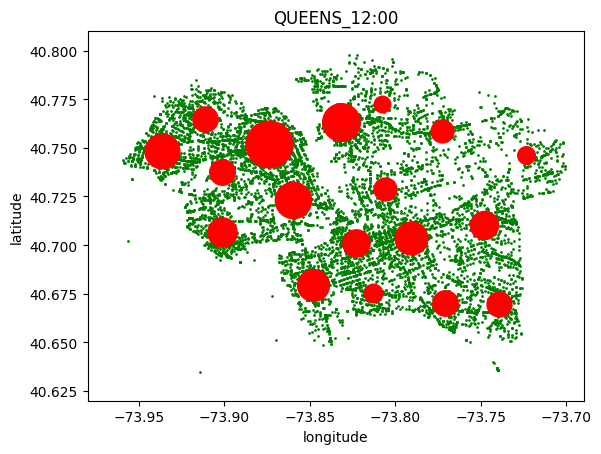

In [55]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_12:00")

In [56]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.772374171229046, -73.80801359134078, 358],
 [40.6702222550091, -73.77081783333333, 550],
 [40.723178053071884, -73.85991391568626, 784],
 [40.60035962357142, -73.75964941071429, 280],
 [40.74840059058824, -73.93641427973857, 752],
 [40.679621455571635, -73.84799064023153, 687],
 [40.67545528765433, -73.81289718493827, 401],
 [40.746490449473676, -73.72389503342104, 380],
 [40.73770915811321, -73.90158412886791, 551],
 [40.76477540427046, -73.91118545533807, 545],
 [40.587557298437495, -73.82372727968749, 192],
 [40.66970961375464, -73.73928161505577, 539],
 [40.701330974659875, -73.82324962619046, 589],
 [40.70675668333333, -73.90156076378204, 630],
 [40.76324505159705, -73.8317720563882, 814],
 [40.75841616499999, -73.7730381544, 492],
 [40.710245302145225, -73.74798748547856, 606],
 [40.70345862206304, -73.7911608333811, 707],
 [40.72880989055441, -73.8059982164271, 496],
 [40.75190391968963, -73.87409853743938, 1010]]

### 13:00

In [57]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='13:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
| 40.67478|-73.806206| QUEENS|13:00:00|[40.67478,-73.806...|
| 40.73844| -73.88628| QUEENS|13:00:00|[40.73844,-73.88628]|
| 40.69814| -73.89111| QUEENS|13:00:00|[40.69814,-73.89111]|
|40.702335| -73.89073| QUEENS|13:00:00|[40.702335,-73.89...|
|40.712776| -73.90601| QUEENS|13:00:00|[40.712776,-73.90...|
| 40.72166|-73.888664| QUEENS|13:00:00|[40.72166,-73.888...|
|40.757725|-73.779274| QUEENS|13:00:00|[40.757725,-73.77...|
|40.671448| -73.78943| QUEENS|13:00:00|[40.671448,-73.78...|
|40.732857| -73.79857| QUEENS|13:00:00|[40.732857,-73.79...|
|40.732533| -73.76565| QUEENS|13:00:00|[40.732533,-73.76...|
| 40.76536| -73.82787| QUEENS|13:00:00|[40.76536,-73.82787]|
|40.703205|-73.865456| QUEENS|13:00:00|[40.703205,-73.86...|
|40.595802|-73.764656| QUEENS|13:00:00|[40.595802,-73.76...|
|40.601112| -73.75187| Q

In [58]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
| 40.67478|-73.806206| QUEENS|13:00:00|[40.67478,-73.806...|        15|
| 40.73844| -73.88628| QUEENS|13:00:00|[40.73844,-73.88628]|        17|
| 40.69814| -73.89111| QUEENS|13:00:00|[40.69814,-73.89111]|        12|
|40.702335| -73.89073| QUEENS|13:00:00|[40.702335,-73.89...|        12|
|40.712776| -73.90601| QUEENS|13:00:00|[40.712776,-73.90...|        12|
| 40.72166|-73.888664| QUEENS|13:00:00|[40.72166,-73.888...|        12|
|40.757725|-73.779274| QUEENS|13:00:00|[40.757725,-73.77...|        18|
|40.671448| -73.78943| QUEENS|13:00:00|[40.671448,-73.78...|        15|
|40.732857| -73.79857| QUEENS|13:00:00|[40.732857,-73.79...|         0|
|40.732533| -73.76565| QUEENS|13:00:00|[40.732533,-73.76...|        16|
| 40.76536| -73.82787| QUEENS|13:00:00|[40.76536,-73.82787]|    

Text(0.5, 1.0, 'QUEENS_13:00')

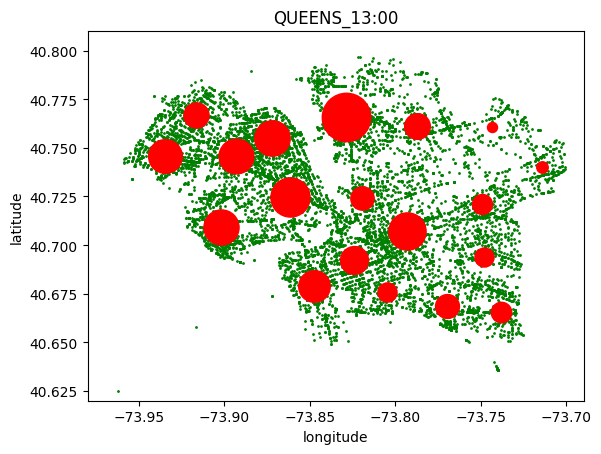

In [59]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_13:00")

In [60]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.72418492046332, -73.8193953254826, 505],
 [40.76665139119267, -73.91686056, 544],
 [40.74574355, -73.9349693479339, 729],
 [40.668675662934355, -73.7697942318533, 516],
 [40.692563902653404, -73.82399711973466, 604],
 [40.66565191548975, -73.738489876082, 441],
 [40.679156334927534, -73.84775649304346, 683],
 [40.765629728979974, -73.82860173708293, 1047],
 [40.76084228709677, -73.74359971751151, 217],
 [40.694119062043804, -73.74829351824818, 412],
 [40.75516087612501, -73.87200408624999, 765],
 [40.594755761842094, -73.78503371885967, 456],
 [40.70945134076516, -73.90184165659629, 759],
 [40.70741826177945, -73.79348540664161, 804],
 [40.73991154153226, -73.71430686693547, 248],
 [40.67590145222773, -73.80484219727722, 414],
 [40.72094730023147, -73.74930987106481, 432],
 [40.745603429050284, -73.89296909497206, 752],
 [40.76143656900901, -73.78726173963965, 555],
 [40.724881724497045, -73.86138031573964, 845]]

### 14:00

In [61]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='14:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
|40.593636|-73.797264| QUEENS|14:00:00|[40.593636,-73.79...|
|40.697083| -73.85476| QUEENS|14:00:00|[40.697083,-73.85...|
|40.609535| -73.75372| QUEENS|14:00:00|[40.609535,-73.75...|
| 40.75184| -73.90358| QUEENS|14:00:00|[40.75184,-73.90358]|
|40.662476|-73.768326| QUEENS|14:00:00|[40.662476,-73.76...|
|  40.7158|-73.824486| QUEENS|14:00:00|[40.7158,-73.824486]|
|40.781647|-73.833664| QUEENS|14:00:00|[40.781647,-73.83...|
| 40.71275|  -73.7673| QUEENS|14:00:00| [40.71275,-73.7673]|
| 40.66305| -73.74874| QUEENS|14:00:00|[40.66305,-73.74874]|
| 40.71178| -73.91737| QUEENS|14:00:00|[40.71178,-73.91737]|
| 40.66377| -73.76881| QUEENS|14:00:00|[40.66377,-73.76881]|
| 40.71058| -73.87064| QUEENS|14:00:00|[40.71058,-73.87064]|
|40.757977| -73.88297| QUEENS|14:00:00|[40.757977,-73.88...|
| 40.59702|-73.749084| Q

In [62]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
|40.593636|-73.797264| QUEENS|14:00:00|[40.593636,-73.79...|         6|
|40.697083| -73.85476| QUEENS|14:00:00|[40.697083,-73.85...|         9|
|40.609535| -73.75372| QUEENS|14:00:00|[40.609535,-73.75...|        11|
| 40.75184| -73.90358| QUEENS|14:00:00|[40.75184,-73.90358]|         8|
|40.662476|-73.768326| QUEENS|14:00:00|[40.662476,-73.76...|        10|
|  40.7158|-73.824486| QUEENS|14:00:00|[40.7158,-73.824486]|        17|
|40.781647|-73.833664| QUEENS|14:00:00|[40.781647,-73.83...|        12|
| 40.71275|  -73.7673| QUEENS|14:00:00| [40.71275,-73.7673]|         4|
| 40.66305| -73.74874| QUEENS|14:00:00|[40.66305,-73.74874]|         1|
| 40.71178| -73.91737| QUEENS|14:00:00|[40.71178,-73.91737]|         2|
| 40.66377| -73.76881| QUEENS|14:00:00|[40.66377,-73.76881]|    

Text(0.5, 1.0, 'QUEENS_14:00')

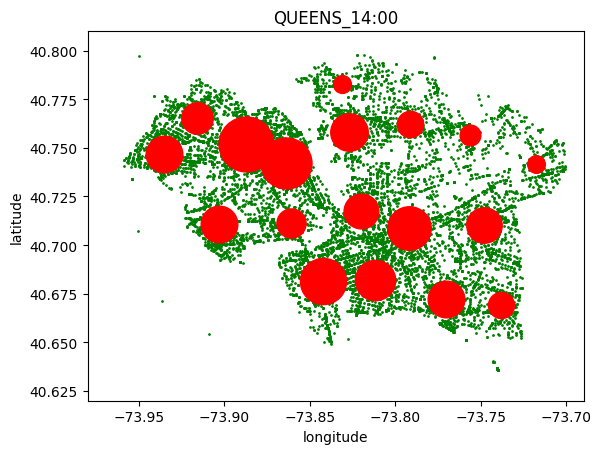

In [63]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_14:00")

In [64]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.76533833201175, -73.91596102775331, 681],
 [40.66931893067376, -73.73852532180851, 564],
 [40.71088428371212, -73.90327641755053, 792],
 [40.708731367331936, -73.79186010063023, 940],
 [40.71009252650131, -73.74846335887729, 766],
 [40.75811541183724, -73.82694795622689, 811],
 [40.58712507089202, -73.82373605258216, 213],
 [40.75643665167038, -73.75610905300667, 449],
 [40.751862043676226, -73.88732709839796, 1186],
 [40.7114631082671, -73.86126341796502, 630],
 [40.672217374148794, -73.77024955056746, 793],
 [40.600558623351645, -73.76111105384616, 364],
 [40.78257012176165, -73.83105920803109, 386],
 [40.7421127740472, -73.86422206878403, 1102],
 [40.741479249081365, -73.71756185616796, 381],
 [40.68157850623116, -73.84238415768846, 997],
 [40.681860949019615, -73.81208747531718, 872],
 [40.71728262082777, -73.8203427895861, 753],
 [40.7469047489899, -73.93499968282828, 792],
 [40.76247862736843, -73.79155459877195, 570]]

### 15:00

In [65]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='15:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
|40.745235|-73.937706| QUEENS|15:00:00|[40.745235,-73.93...|
|40.722515| -73.73332| QUEENS|15:00:00|[40.722515,-73.73...|
| 40.73464| -73.87421| QUEENS|15:00:00|[40.73464,-73.87421]|
|40.794773|-73.816185| QUEENS|15:00:00|[40.794773,-73.81...|
| 40.77451|-73.838036| QUEENS|15:00:00|[40.77451,-73.838...|
| 40.72304|  -73.8563| QUEENS|15:00:00| [40.72304,-73.8563]|
|40.748024| -73.88021| QUEENS|15:00:00|[40.748024,-73.88...|
| 40.68866| -73.86588| QUEENS|15:00:00|[40.68866,-73.86588]|
| 40.60303| -73.75316| QUEENS|15:00:00|[40.60303,-73.75316]|
|40.665257|-73.739555| QUEENS|15:00:00|[40.665257,-73.73...|
|40.665348| -73.72986| QUEENS|15:00:00|[40.665348,-73.72...|
|40.666378|-73.847694| QUEENS|15:00:00|[40.666378,-73.84...|
| 40.66561| -73.73568| QUEENS|15:00:00|[40.66561,-73.73568]|
| 40.67431|-73.800644| Q

In [66]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
|40.745235|-73.937706| QUEENS|15:00:00|[40.745235,-73.93...|         1|
|40.722515| -73.73332| QUEENS|15:00:00|[40.722515,-73.73...|         7|
| 40.73464| -73.87421| QUEENS|15:00:00|[40.73464,-73.87421]|         6|
|40.794773|-73.816185| QUEENS|15:00:00|[40.794773,-73.81...|        19|
| 40.77451|-73.838036| QUEENS|15:00:00|[40.77451,-73.838...|        19|
| 40.72304|  -73.8563| QUEENS|15:00:00| [40.72304,-73.8563]|         6|
|40.748024| -73.88021| QUEENS|15:00:00|[40.748024,-73.88...|         9|
| 40.68866| -73.86588| QUEENS|15:00:00|[40.68866,-73.86588]|         3|
| 40.60303| -73.75316| QUEENS|15:00:00|[40.60303,-73.75316]|         8|
|40.665257|-73.739555| QUEENS|15:00:00|[40.665257,-73.73...|        13|
|40.665348| -73.72986| QUEENS|15:00:00|[40.665348,-73.72...|    

Text(0.5, 1.0, 'QUEENS_15:00')

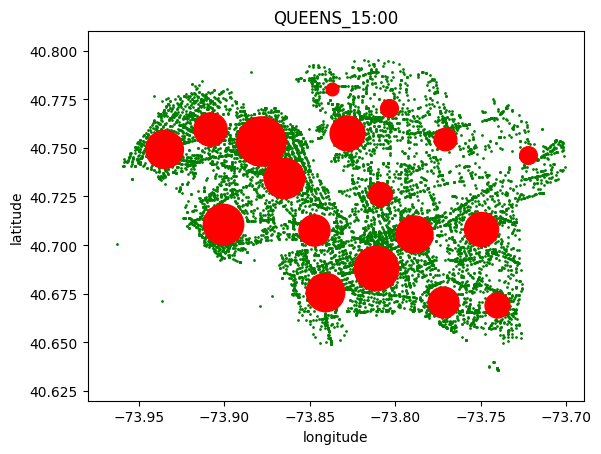

In [67]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_15:00")

In [68]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.67092584910179, -73.77204692784431, 668],
 [40.749235751757574, -73.93535553284849, 816],
 [40.77032444583333, -73.80353810182291, 384],
 [40.7077853877612, -73.84729564388059, 673],
 [40.58868608816328, -73.81831160734696, 245],
 [40.705848958249994, -73.789090345875, 800],
 [40.734726339647054, -73.86487880282353, 871],
 [40.708032512534054, -73.7498534079019, 734],
 [40.60157186996997, -73.75622277027028, 333],
 [40.75347053520458, -73.87856956489058, 1064],
 [40.75963869853529, -73.90858929853529, 719],
 [40.71109022983871, -73.90080141186634, 872],
 [40.726306057031245, -73.8089820875, 512],
 [40.66925395324676, -73.74050320519478, 539],
 [40.74619828612566, -73.72266602801048, 382],
 [40.75765004162234, -73.82821310984043, 752],
 [40.676139123281075, -73.84106606887818, 829],
 [40.68837674504693, -73.81150271939521, 959],
 [40.75470989958932, -73.77126343552361, 487],
 [40.78010200549451, -73.83721494175825, 273]]

### 16:00

In [69]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='16:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+------------------+----------+-------+--------+--------------------+
|          latitude| longitude|borough|    time|            features|
+------------------+----------+-------+--------+--------------------+
|40.675883999999996| -73.75577| QUEENS|16:00:00|[40.6758839999999...|
|         40.734375| -73.87342| QUEENS|16:00:00|[40.734375,-73.87...|
|         40.699947|-73.736626| QUEENS|16:00:00|[40.699947,-73.73...|
|         40.589592|-73.786385| QUEENS|16:00:00|[40.589592,-73.78...|
|         40.777496| -73.90784| QUEENS|16:00:00|[40.777496,-73.90...|
|         40.741634| -73.88266| QUEENS|16:00:00|[40.741634,-73.88...|
|         40.680477|  -73.7921| QUEENS|16:00:00|[40.680477,-73.7921]|
|         40.740276| -73.92782| QUEENS|16:00:00|[40.740276,-73.92...|
|         40.694294| -73.74868| QUEENS|16:00:00|[40.694294,-73.74...|
|          40.71363|-73.917885| QUEENS|16:00:00|[40.71363,-73.917...|
|         40.758156| -73.89627| QUEENS|16:00:00|[40.758156,-73.89...|
|         40.778625|

In [70]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+------------------+----------+-------+--------+--------------------+----------+
|          latitude| longitude|borough|    time|            features|prediction|
+------------------+----------+-------+--------+--------------------+----------+
|40.675883999999996| -73.75577| QUEENS|16:00:00|[40.6758839999999...|        15|
|         40.734375| -73.87342| QUEENS|16:00:00|[40.734375,-73.87...|        13|
|         40.699947|-73.736626| QUEENS|16:00:00|[40.699947,-73.73...|         4|
|         40.589592|-73.786385| QUEENS|16:00:00|[40.589592,-73.78...|        18|
|         40.777496| -73.90784| QUEENS|16:00:00|[40.777496,-73.90...|        16|
|         40.741634| -73.88266| QUEENS|16:00:00|[40.741634,-73.88...|         3|
|         40.680477|  -73.7921| QUEENS|16:00:00|[40.680477,-73.7921]|         7|
|         40.740276| -73.92782| QUEENS|16:00:00|[40.740276,-73.92...|        10|
|         40.694294| -73.74868| QUEENS|16:00:00|[40.694294,-73.74...|         4|
|          40.71363|-73.9178

Text(0.5, 1.0, 'QUEENS_16:00')

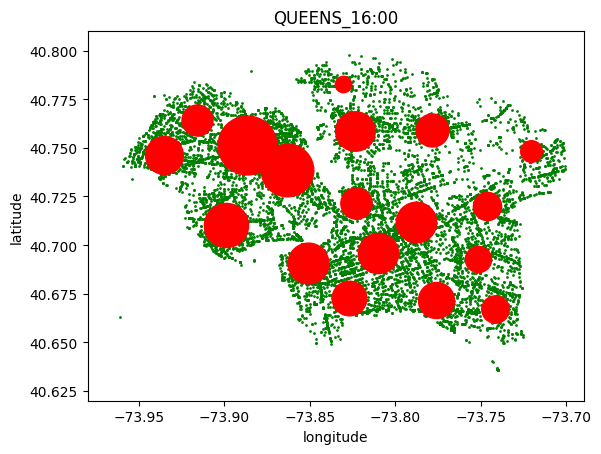

In [71]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_16:00")

In [72]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.690891364926216, -73.85083366833145, 880],
 [40.75913833651685, -73.77834038890448, 712],
 [40.601171876331364, -73.75737965177515, 338],
 [40.751660469200615, -73.88682037225706, 1272],
 [40.693016882446805, -73.75144143776595, 565],
 [40.782689679436615, -73.83053022140844, 355],
 [40.69586433306452, -73.81042462327189, 870],
 [40.672027536410255, -73.77633975756409, 779],
 [40.71987672160393, -73.74671513322421, 610],
 [40.75842974941314, -73.82359375399062, 853],
 [40.74649425293398, -73.93547779217603, 818],
 [40.710311760084025, -73.89918096228989, 954],
 [40.74821691391863, -73.72069066209852, 467],
 [40.73843188054578, -73.86326282121479, 1137],
 [40.67265001954484, -73.82721856720215, 748],
 [40.66694551703203, -73.74186460522766, 593],
 [40.764353227313435, -73.91586648805972, 670],
 [40.72170707142856, -73.82285357083946, 677],
 [40.588858231896545, -73.8161779599138, 232],
 [40.711732704581905, -73.78807059026347, 874]]

### 17:00

In [73]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='17:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
|40.675167|-73.825264| QUEENS|17:00:00|[40.675167,-73.82...|
|40.609535| -73.75372| QUEENS|17:00:00|[40.609535,-73.75...|
|40.708923| -73.81877| QUEENS|17:00:00|[40.708923,-73.81...|
|40.748962| -73.89176| QUEENS|17:00:00|[40.748962,-73.89...|
|40.688435| -73.78765| QUEENS|17:00:00|[40.688435,-73.78...|
| 40.68329| -73.85491| QUEENS|17:00:00|[40.68329,-73.85491]|
|40.675255| -73.73207| QUEENS|17:00:00|[40.675255,-73.73...|
| 40.73197| -73.78651| QUEENS|17:00:00|[40.73197,-73.78651]|
| 40.66406| -73.73846| QUEENS|17:00:00|[40.66406,-73.73846]|
| 40.74661| -73.86473| QUEENS|17:00:00|[40.74661,-73.86473]|
|40.733723| -73.72516| QUEENS|17:00:00|[40.733723,-73.72...|
| 40.71493| -73.79316| QUEENS|17:00:00|[40.71493,-73.79316]|
|40.738068|-73.861046| QUEENS|17:00:00|[40.738068,-73.86...|
|40.761303| -73.86043| Q

In [74]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
|40.675167|-73.825264| QUEENS|17:00:00|[40.675167,-73.82...|        12|
|40.609535| -73.75372| QUEENS|17:00:00|[40.609535,-73.75...|        17|
|40.708923| -73.81877| QUEENS|17:00:00|[40.708923,-73.81...|         8|
|40.748962| -73.89176| QUEENS|17:00:00|[40.748962,-73.89...|         4|
|40.688435| -73.78765| QUEENS|17:00:00|[40.688435,-73.78...|         2|
| 40.68329| -73.85491| QUEENS|17:00:00|[40.68329,-73.85491]|         9|
|40.675255| -73.73207| QUEENS|17:00:00|[40.675255,-73.73...|        15|
| 40.73197| -73.78651| QUEENS|17:00:00|[40.73197,-73.78651]|         6|
| 40.66406| -73.73846| QUEENS|17:00:00|[40.66406,-73.73846]|        15|
| 40.74661| -73.86473| QUEENS|17:00:00|[40.74661,-73.86473]|        18|
|40.733723| -73.72516| QUEENS|17:00:00|[40.733723,-73.72...|    

Text(0.5, 1.0, 'QUEENS_17:00')

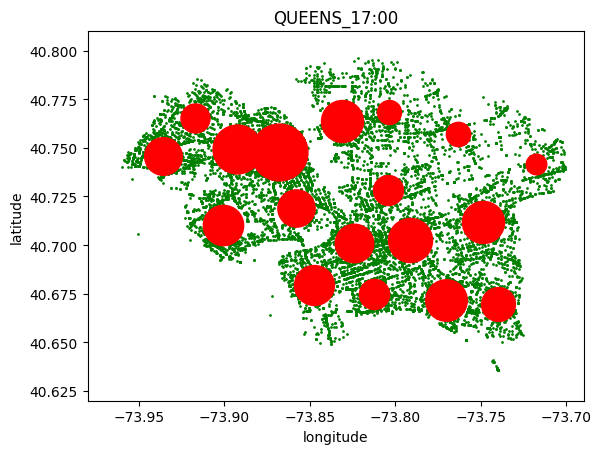

In [75]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_17:00")

In [76]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.7416440222472, -73.71795661258429, 445],
 [40.74597888843789, -73.93570459102091, 813],
 [40.70241568331584, -73.79135751710388, 953],
 [40.76396868974643, -73.83112679084896, 907],
 [40.749505312689394, -73.89261337443183, 1056],
 [40.7189819398263, -73.85802748362282, 806],
 [40.72855327762346, -73.80450037222221, 648],
 [40.71183824235423, -73.74887099867986, 909],
 [40.70121734098558, -73.82414734122597, 832],
 [40.67950266431053, -73.84782010382386, 863],
 [40.71047805132033, -73.90085183823193, 871],
 [40.586858382191764, -73.82090647579908, 219],
 [40.675027195852536, -73.81277711044548, 651],
 [40.67169548996655, -73.77036681248606, 897],
 [40.76836211216216, -73.80350109961388, 518],
 [40.66988736325136, -73.73982774030054, 732],
 [40.765193503508776, -73.91727456012758, 627],
 [40.60054349050847, -73.76101781491525, 295],
 [40.7480106776873, -73.86825259600977, 1228],
 [40.757141637333326, -73.76360101638096, 525]]

### 18:00

In [77]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='18:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
| 40.76532|-73.771904| QUEENS|18:00:00|[40.76532,-73.771...|
|40.678417|-73.729225| QUEENS|18:00:00|[40.678417,-73.72...|
| 40.72218| -73.84406| QUEENS|18:00:00|[40.72218,-73.84406]|
|40.598515|-73.766464| QUEENS|18:00:00|[40.598515,-73.76...|
| 40.72313| -73.90614| QUEENS|18:00:00|[40.72313,-73.90614]|
|40.734863|-73.862656| QUEENS|18:00:00|[40.734863,-73.86...|
|40.696987| -73.85283| QUEENS|18:00:00|[40.696987,-73.85...|
|40.756256| -73.85773| QUEENS|18:00:00|[40.756256,-73.85...|
|40.601437|-73.768196| QUEENS|18:00:00|[40.601437,-73.76...|
|40.721592|  -73.7576| QUEENS|18:00:00|[40.721592,-73.7576]|
|40.721485| -73.86658| QUEENS|18:00:00|[40.721485,-73.86...|
|40.696186|-73.751976| QUEENS|18:00:00|[40.696186,-73.75...|
|40.738365| -73.71261| QUEENS|18:00:00|[40.738365,-73.71...|
|40.666393| -73.75177| Q

In [78]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
| 40.76532|-73.771904| QUEENS|18:00:00|[40.76532,-73.771...|         5|
|40.678417|-73.729225| QUEENS|18:00:00|[40.678417,-73.72...|         8|
| 40.72218| -73.84406| QUEENS|18:00:00|[40.72218,-73.84406]|        14|
|40.598515|-73.766464| QUEENS|18:00:00|[40.598515,-73.76...|         1|
| 40.72313| -73.90614| QUEENS|18:00:00|[40.72313,-73.90614]|        10|
|40.734863|-73.862656| QUEENS|18:00:00|[40.734863,-73.86...|        18|
|40.696987| -73.85283| QUEENS|18:00:00|[40.696987,-73.85...|        14|
|40.756256| -73.85773| QUEENS|18:00:00|[40.756256,-73.85...|        13|
|40.601437|-73.768196| QUEENS|18:00:00|[40.601437,-73.76...|         1|
|40.721592|  -73.7576| QUEENS|18:00:00|[40.721592,-73.7576]|        17|
|40.721485| -73.86658| QUEENS|18:00:00|[40.721485,-73.86...|    

Text(0.5, 1.0, 'QUEENS_18:00')

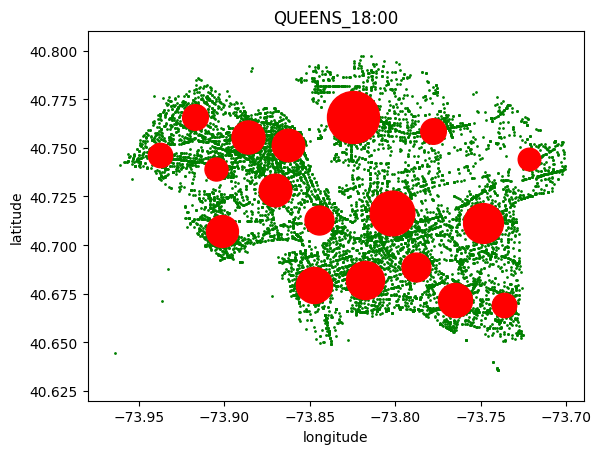

In [79]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_18:00")

In [80]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.76574714233512, -73.82463273734402, 1123],
 [40.60050659175627, -73.75951808458782, 279],
 [40.765744317328526, -73.91717372202167, 554],
 [40.74422022520493, -73.72176508565575, 488],
 [40.716583447619044, -73.80206250445134, 965],
 [40.75853826184448, -73.77793431103075, 553],
 [40.74637093079848, -73.9376699538023, 526],
 [40.6716339888738, -73.76498729647219, 737],
 [40.66926575749526, -73.7366831459203, 527],
 [40.67941427935898, -73.84736709589744, 780],
 [40.73905636016097, -73.9047699275654, 498],
 [40.58724231437909, -73.82172687385622, 153],
 [40.75538105740223, -73.88644639050281, 715],
 [40.75171166199422, -73.86302034190753, 702],
 [40.71271588038278, -73.8444369709729, 626],
 [40.688759116720256, -73.78813534469454, 622],
 [40.70729680203488, -73.90128831540697, 688],
 [40.71142700418604, -73.7489271694186, 860],
 [40.728260831372545, -73.87062126610643, 705],
 [40.681876684063255, -73.81805131763993, 822]]

### 19:00

In [81]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='19:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
| 40.69349|-73.826546| QUEENS|19:00:00|[40.69349,-73.826...|
|40.678364| -73.77949| QUEENS|19:00:00|[40.678364,-73.77...|
| 40.70399| -73.85589| QUEENS|19:00:00|[40.70399,-73.85589]|
|40.747536| -73.89344| QUEENS|19:00:00|[40.747536,-73.89...|
|40.786854| -73.82236| QUEENS|19:00:00|[40.786854,-73.82...|
|40.711353| -73.77518| QUEENS|19:00:00|[40.711353,-73.77...|
|40.594105| -73.79242| QUEENS|19:00:00|[40.594105,-73.79...|
|40.665497| -73.75573| QUEENS|19:00:00|[40.665497,-73.75...|
|40.737614| -73.79646| QUEENS|19:00:00|[40.737614,-73.79...|
|40.749866| -73.86273| QUEENS|19:00:00|[40.749866,-73.86...|
|40.751575| -73.85584| QUEENS|19:00:00|[40.751575,-73.85...|
| 40.69756| -73.85275| QUEENS|19:00:00|[40.69756,-73.85275]|
|  40.6934| -73.75602| QUEENS|19:00:00| [40.6934,-73.75602]|
|40.728283| -73.82941| Q

In [82]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
| 40.69349|-73.826546| QUEENS|19:00:00|[40.69349,-73.826...|        15|
|40.678364| -73.77949| QUEENS|19:00:00|[40.678364,-73.77...|        18|
| 40.70399| -73.85589| QUEENS|19:00:00|[40.70399,-73.85589]|         2|
|40.747536| -73.89344| QUEENS|19:00:00|[40.747536,-73.89...|         3|
|40.786854| -73.82236| QUEENS|19:00:00|[40.786854,-73.82...|        12|
|40.711353| -73.77518| QUEENS|19:00:00|[40.711353,-73.77...|        16|
|40.594105| -73.79242| QUEENS|19:00:00|[40.594105,-73.79...|         9|
|40.665497| -73.75573| QUEENS|19:00:00|[40.665497,-73.75...|        18|
|40.737614| -73.79646| QUEENS|19:00:00|[40.737614,-73.79...|        19|
|40.749866| -73.86273| QUEENS|19:00:00|[40.749866,-73.86...|        10|
|40.751575| -73.85584| QUEENS|19:00:00|[40.751575,-73.85...|    

Text(0.5, 1.0, 'QUEENS_19:00')

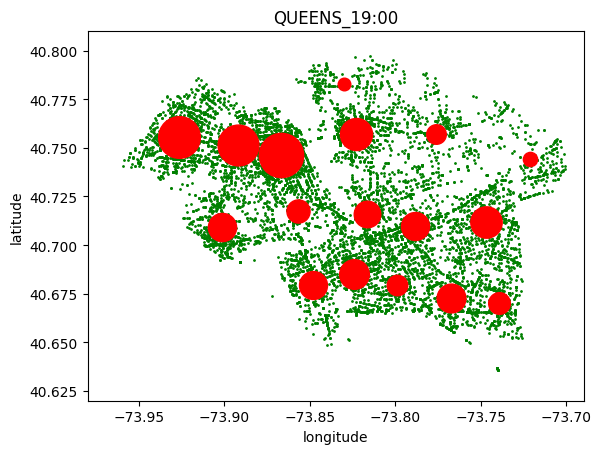

In [83]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_19:00")

In [84]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.75718035367965, -73.82274353160173, 693],
 [40.670294239743605, -73.73916579166666, 468],
 [40.71758809658635, -73.85720106606425, 500],
 [40.75155530831461, -73.8921852411236, 882],
 [40.75580180687361, -73.92666235875832, 901],
 [40.70948601581549, -73.90161470032949, 609],
 [40.74414660616883, -73.72157085227273, 308],
 [40.711647154719756, -73.74712456179942, 678],
 [40.67959612760182, -73.79930611628961, 443],
 [40.58718871744966, -73.81962722751678, 149],
 [40.74623731025907, -73.8670029711917, 957],
 [40.599713592574254, -73.7611078178218, 202],
 [40.78261494981685, -73.83019301465202, 273],
 [40.71574976719299, -73.81682490403509, 574],
 [40.55845, -73.92080999999999, 3],
 [40.684945421583855, -73.82410513136645, 641],
 [40.70969449966832, -73.78825840398011, 605],
 [40.679334989376045, -73.84827615868466, 604],
 [40.6729859099359, -73.76754520705127, 623],
 [40.757250870283016, -73.77631298160377, 423]]

### 20:00

In [85]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='20:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
| 40.69261| -73.81143| QUEENS|20:00:00|[40.69261,-73.81143]|
|40.752777| -73.70743| QUEENS|20:00:00|[40.752777,-73.70...|
|  40.6639|  -73.7804| QUEENS|20:00:00|  [40.6639,-73.7804]|
|40.703217| -73.73427| QUEENS|20:00:00|[40.703217,-73.73...|
| 40.60677|-73.759575| QUEENS|20:00:00|[40.60677,-73.759...|
|40.781715|-73.823845| QUEENS|20:00:00|[40.781715,-73.82...|
| 40.76803| -73.87722| QUEENS|20:00:00|[40.76803,-73.87722]|
|40.763546| -73.88209| QUEENS|20:00:00|[40.763546,-73.88...|
|40.715252| -73.74891| QUEENS|20:00:00|[40.715252,-73.74...|
| 40.74456| -73.95598| QUEENS|20:00:00|[40.74456,-73.95598]|
|40.601112| -73.76122| QUEENS|20:00:00|[40.601112,-73.76...|
|40.685432| -73.75514| QUEENS|20:00:00|[40.685432,-73.75...|
| 40.67102| -73.74893| QUEENS|20:00:00|[40.67102,-73.74893]|
|40.703938| -73.87605| Q

In [86]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
| 40.69261| -73.81143| QUEENS|20:00:00|[40.69261,-73.81143]|        14|
|40.752777| -73.70743| QUEENS|20:00:00|[40.752777,-73.70...|         9|
|  40.6639|  -73.7804| QUEENS|20:00:00|  [40.6639,-73.7804]|        18|
|40.703217| -73.73427| QUEENS|20:00:00|[40.703217,-73.73...|        17|
| 40.60677|-73.759575| QUEENS|20:00:00|[40.60677,-73.759...|         6|
|40.781715|-73.823845| QUEENS|20:00:00|[40.781715,-73.82...|        16|
| 40.76803| -73.87722| QUEENS|20:00:00|[40.76803,-73.87722]|         7|
|40.763546| -73.88209| QUEENS|20:00:00|[40.763546,-73.88...|         7|
|40.715252| -73.74891| QUEENS|20:00:00|[40.715252,-73.74...|        17|
| 40.74456| -73.95598| QUEENS|20:00:00|[40.74456,-73.95598]|         3|
|40.601112| -73.76122| QUEENS|20:00:00|[40.601112,-73.76...|    

Text(0.5, 1.0, 'QUEENS_20:00')

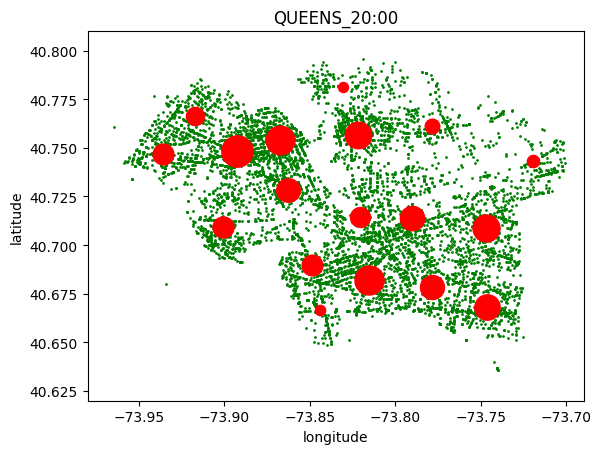

In [87]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_20:00")

In [88]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.71416967658349, -73.79025853282148, 526],
 [40.71433459396751, -73.82052061113689, 431],
 [40.667981380434775, -73.74636278731884, 548],
 [40.74688119066667, -73.93572200711111, 450],
 [40.70904952737306, -73.90067179448123, 453],
 [40.748282634171595, -73.8925960794379, 676],
 [40.60011580841584, -73.76073877128714, 202],
 [40.7542568766129, -73.86766829112905, 620],
 [40.756582258741254, -73.82181551066431, 572],
 [40.74325512878788, -73.7194105625, 264],
 [40.766296518112235, -73.91689951964284, 392],
 [40.58469534433963, -73.82564062830187, 106],
 [40.689922624330364, -73.84864937343751, 448],
 [40.76119936952381, -73.77867891650793, 316],
 [40.68209221365079, -73.81516177428571, 627],
 [40.66680817309417, -73.84415203632287, 223],
 [40.78114380184332, -73.83036458202764, 217],
 [40.708980064455794, -73.74679811139455, 582],
 [40.678249886328125, -73.77848917675782, 519],
 [40.72826438762278, -73.86304591611, 509]]

### 21:00

In [89]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='21:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
|40.758705| -73.93793| QUEENS|21:00:00|[40.758705,-73.93...|
|40.695156|-73.845406| QUEENS|21:00:00|[40.695156,-73.84...|
|40.776764|-73.848015| QUEENS|21:00:00|[40.776764,-73.84...|
|40.726463| -73.85943| QUEENS|21:00:00|[40.726463,-73.85...|
|40.686646|-73.849075| QUEENS|21:00:00|[40.686646,-73.84...|
| 40.69674| -73.76292| QUEENS|21:00:00|[40.69674,-73.76292]|
|40.708534|-73.914925| QUEENS|21:00:00|[40.708534,-73.91...|
| 40.71402| -73.74827| QUEENS|21:00:00|[40.71402,-73.74827]|
|40.758224| -73.91741| QUEENS|21:00:00|[40.758224,-73.91...|
| 40.68561| -73.80654| QUEENS|21:00:00|[40.68561,-73.80654]|
|40.701385|-73.804115| QUEENS|21:00:00|[40.701385,-73.80...|
|40.675766| -73.81685| QUEENS|21:00:00|[40.675766,-73.81...|
| 40.73376| -73.93743| QUEENS|21:00:00|[40.73376,-73.93743]|
| 40.74525| -73.95575| Q

In [90]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
|40.758705| -73.93793| QUEENS|21:00:00|[40.758705,-73.93...|         1|
|40.695156|-73.845406| QUEENS|21:00:00|[40.695156,-73.84...|        13|
|40.776764|-73.848015| QUEENS|21:00:00|[40.776764,-73.84...|         5|
|40.726463| -73.85943| QUEENS|21:00:00|[40.726463,-73.85...|         8|
|40.686646|-73.849075| QUEENS|21:00:00|[40.686646,-73.84...|        13|
| 40.69674| -73.76292| QUEENS|21:00:00|[40.69674,-73.76292]|        14|
|40.708534|-73.914925| QUEENS|21:00:00|[40.708534,-73.91...|         6|
| 40.71402| -73.74827| QUEENS|21:00:00|[40.71402,-73.74827]|         2|
|40.758224| -73.91741| QUEENS|21:00:00|[40.758224,-73.91...|        11|
| 40.68561| -73.80654| QUEENS|21:00:00|[40.68561,-73.80654]|         0|
|40.701385|-73.804115| QUEENS|21:00:00|[40.701385,-73.80...|    

Text(0.5, 1.0, 'QUEENS_21:00')

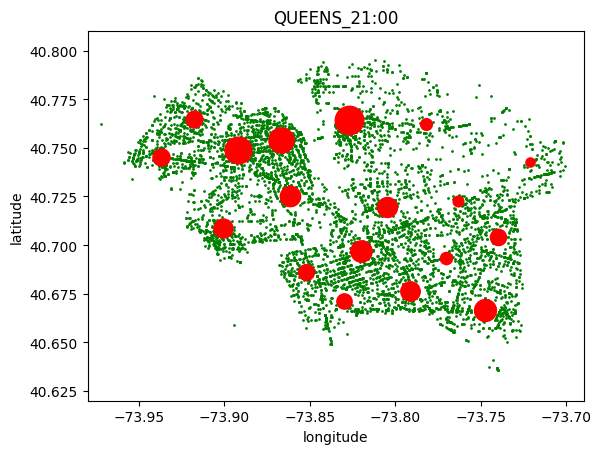

In [91]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_21:00")

In [92]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.69681165474138, -73.81997466874999, 461],
 [40.74520951891892, -73.93714250594594, 370],
 [40.70421896494253, -73.73999354568964, 350],
 [40.748978731228064, -73.8917386605263, 577],
 [40.666503430866804, -73.74781132980974, 474],
 [40.764234204078306, -73.8269370132137, 615],
 [40.70884397684729, -73.90101053201971, 410],
 [40.72276062629311, -73.76342848836207, 231],
 [40.72523686114942, -73.86174868551724, 439],
 [40.71973206111111, -73.80478959884259, 432],
 [40.67649156935867, -73.79120974299289, 420],
 [40.76460674265928, -73.91771267673131, 361],
 [40.753798587900356, -73.86710222153025, 543],
 [40.686306244281525, -73.85223627595309, 343],
 [40.693484923863636, -73.77023286969698, 264],
 [40.67116077453987, -73.83011450214724, 330],
 [40.74295606060606, -73.7214160787879, 198],
 [40.589604943333335, -73.81357093111112, 90],
 [40.60158986621622, -73.75779409256756, 148],
 [40.762464543921574, -73.78227719490197, 253]]

### 22:00

In [93]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='22:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
|40.727375| -73.90313| QUEENS|22:00:00|[40.727375,-73.90...|
|40.680088| -73.80177| QUEENS|22:00:00|[40.680088,-73.80...|
|40.742065| -73.90036| QUEENS|22:00:00|[40.742065,-73.90...|
|40.679012|-73.758675| QUEENS|22:00:00|[40.679012,-73.75...|
|40.764187| -73.86258| QUEENS|22:00:00|[40.764187,-73.86...|
|40.693817| -73.82212| QUEENS|22:00:00|[40.693817,-73.82...|
|40.748913|  -73.9374| QUEENS|22:00:00|[40.748913,-73.9374]|
|40.755203|   -73.871| QUEENS|22:00:00| [40.755203,-73.871]|
| 40.75595| -73.88165| QUEENS|22:00:00|[40.75595,-73.88165]|
|40.729553| -73.72607| QUEENS|22:00:00|[40.729553,-73.72...|
| 40.68804| -73.83275| QUEENS|22:00:00|[40.68804,-73.83275]|
|40.717396| -73.79637| QUEENS|22:00:00|[40.717396,-73.79...|
|40.762524|-73.865555| QUEENS|22:00:00|[40.762524,-73.86...|
| 40.71022| -73.89931| Q

In [94]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
|40.727375| -73.90313| QUEENS|22:00:00|[40.727375,-73.90...|         9|
|40.680088| -73.80177| QUEENS|22:00:00|[40.680088,-73.80...|         0|
|40.742065| -73.90036| QUEENS|22:00:00|[40.742065,-73.90...|        17|
|40.679012|-73.758675| QUEENS|22:00:00|[40.679012,-73.75...|        16|
|40.764187| -73.86258| QUEENS|22:00:00|[40.764187,-73.86...|        14|
|40.693817| -73.82212| QUEENS|22:00:00|[40.693817,-73.82...|         0|
|40.748913|  -73.9374| QUEENS|22:00:00|[40.748913,-73.9374]|        19|
|40.755203|   -73.871| QUEENS|22:00:00| [40.755203,-73.871]|        14|
| 40.75595| -73.88165| QUEENS|22:00:00|[40.75595,-73.88165]|        14|
|40.729553| -73.72607| QUEENS|22:00:00|[40.729553,-73.72...|         3|
| 40.68804| -73.83275| QUEENS|22:00:00|[40.68804,-73.83275]|    

Text(0.5, 1.0, 'QUEENS_22:00')

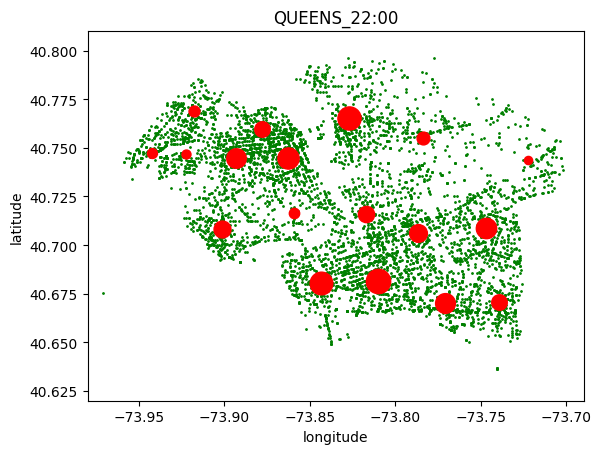

In [95]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_22:00")

In [96]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.68129021958175, -73.81043038536123, 526],
 [40.768806972995776, -73.9180238886076, 237],
 [40.765126761077845, -73.82689464231538, 501],
 [40.743659236158194, -73.72234501977401, 177],
 [40.5968524031915, -73.77884808457448, 188],
 [40.7445335607456, -73.86260454517542, 458],
 [40.67074226845238, -73.73913572589287, 336],
 [40.582239333333334, -73.95196333333332, 3],
 [40.7469830056701, -73.92215342268042, 194],
 [40.708022758196726, -73.90159378169399, 366],
 [40.7062486109375, -73.78701387838541, 384],
 [40.6807625644898, -73.8436257767347, 490],
 [40.70877797386363, -73.74704983795455, 440],
 [40.71675873973214, -73.85903880089286, 224],
 [40.75971493402367, -73.87810408017752, 336],
 [40.71580021079545, -73.81713580625, 352],
 [40.67041312873831, -73.77074829556075, 428],
 [40.744672915402845, -73.8933318457346, 422],
 [40.75505838664259, -73.78385965559568, 277],
 [40.747398535348836, -73.94254464558139, 215]]

### 23:00

In [97]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='23:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="QUEENS")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+-------+--------+--------------------+
| latitude| longitude|borough|    time|            features|
+---------+----------+-------+--------+--------------------+
| 40.66684| -73.78941| QUEENS|23:00:00|[40.66684,-73.78941]|
|40.742508| -73.91788| QUEENS|23:00:00|[40.742508,-73.91...|
|40.676304|-73.816284| QUEENS|23:00:00|[40.676304,-73.81...|
| 40.74606| -73.85583| QUEENS|23:00:00|[40.74606,-73.85583]|
| 40.66615| -73.80575| QUEENS|23:00:00|[40.66615,-73.80575]|
|40.705452| -73.78149| QUEENS|23:00:00|[40.705452,-73.78...|
|40.680496|-73.821365| QUEENS|23:00:00|[40.680496,-73.82...|
|40.672714| -73.75393| QUEENS|23:00:00|[40.672714,-73.75...|
|40.739384| -73.82268| QUEENS|23:00:00|[40.739384,-73.82...|
| 40.68838| -73.80559| QUEENS|23:00:00|[40.68838,-73.80559]|
|40.725994| -73.89843| QUEENS|23:00:00|[40.725994,-73.89...|
| 40.75896| -73.82985| QUEENS|23:00:00|[40.75896,-73.82985]|
| 40.71512| -73.77358| QUEENS|23:00:00|[40.71512,-73.77358]|
|  40.7597| -73.80031| Q

In [98]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+-------+--------+--------------------+----------+
| latitude| longitude|borough|    time|            features|prediction|
+---------+----------+-------+--------+--------------------+----------+
| 40.66684| -73.78941| QUEENS|23:00:00|[40.66684,-73.78941]|         4|
|40.742508| -73.91788| QUEENS|23:00:00|[40.742508,-73.91...|        14|
|40.676304|-73.816284| QUEENS|23:00:00|[40.676304,-73.81...|         2|
| 40.74606| -73.85583| QUEENS|23:00:00|[40.74606,-73.85583]|        10|
| 40.66615| -73.80575| QUEENS|23:00:00|[40.66615,-73.80575]|        13|
|40.705452| -73.78149| QUEENS|23:00:00|[40.705452,-73.78...|         8|
|40.680496|-73.821365| QUEENS|23:00:00|[40.680496,-73.82...|         2|
|40.672714| -73.75393| QUEENS|23:00:00|[40.672714,-73.75...|        17|
|40.739384| -73.82268| QUEENS|23:00:00|[40.739384,-73.82...|         6|
| 40.68838| -73.80559| QUEENS|23:00:00|[40.68838,-73.80559]|        13|
|40.725994| -73.89843| QUEENS|23:00:00|[40.725994,-73.89...|    

Text(0.5, 1.0, 'QUEENS_23:00')

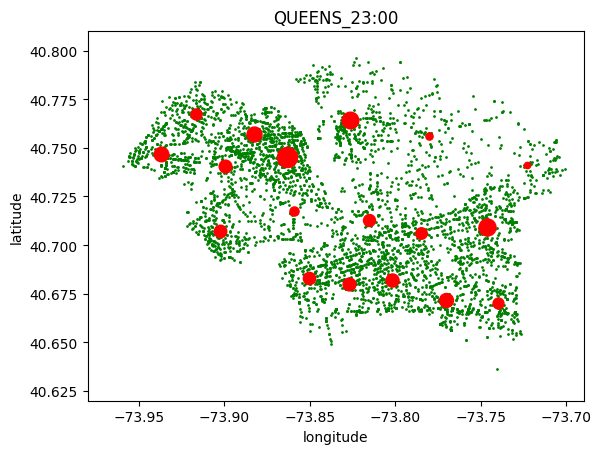

In [99]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_23:00")

In [100]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.746820925878595, -73.9371847482428, 315],
 [40.741375413970594, -73.7229617382353, 136],
 [40.67992388309353, -73.82686167230216, 278],
 [40.70704013458646, -73.90280600413533, 271],
 [40.671999459602645, -73.77036964933774, 302],
 [40.75701872478386, -73.882424681268, 323],
 [40.76431502777778, -73.82640572277778, 359],
 [40.712653902702705, -73.81562703474904, 259],
 [40.70636911485943, -73.7850105309237, 249],
 [40.75612059294871, -73.78007396217947, 156],
 [40.74532458577982, -73.86342542110091, 434],
 [40.598934126984126, -73.77677769761904, 126],
 [40.68288746867925, -73.85025639320756, 265],
 [40.68201144134275, -73.80223022014135, 283],
 [40.74052660756971, -73.89943865139442, 275],
 [40.70946373423912, -73.74669071630434, 368],
 [40.5750249516129, -73.86084002903226, 31],
 [40.67005847076271, -73.74006961525423, 236],
 [40.76723191341465, -73.91675260040653, 242],
 [40.71775545989848, -73.8589886756345, 197]]